In [295]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import category_encoders as ce

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, ConfusionMatrixDisplay, precision_recall_curve
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from datetime import datetime
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from imblearn.ensemble import BalancedRandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVC



import xgboost as xgb
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense


warnings.filterwarnings('ignore')


### Dataset
We have two datasets, one for training called `fraudTrain` and one for testing called `fraudTest`. The train set consists of 1,296,675 transactions and the test one consists of 555,719 transactions.

In [206]:
df = pd.read_csv('./data/fraudTrain.csv')

In [207]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1296675 entries, 0 to 1296674
Data columns (total 23 columns):
 #   Column                 Non-Null Count    Dtype  
---  ------                 --------------    -----  
 0   Unnamed: 0             1296675 non-null  int64  
 1   trans_date_trans_time  1296675 non-null  object 
 2   cc_num                 1296675 non-null  int64  
 3   merchant               1296675 non-null  object 
 4   category               1296675 non-null  object 
 5   amt                    1296675 non-null  float64
 6   first                  1296675 non-null  object 
 7   last                   1296675 non-null  object 
 8   gender                 1296675 non-null  object 
 9   street                 1296675 non-null  object 
 10  city                   1296675 non-null  object 
 11  state                  1296675 non-null  object 
 12  zip                    1296675 non-null  int64  
 13  lat                    1296675 non-null  float64
 14  long              

In [208]:
df_test = pd.read_csv("data/fraudTest.csv")

In [209]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 555719 entries, 0 to 555718
Data columns (total 23 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   Unnamed: 0             555719 non-null  int64  
 1   trans_date_trans_time  555719 non-null  object 
 2   cc_num                 555719 non-null  int64  
 3   merchant               555719 non-null  object 
 4   category               555719 non-null  object 
 5   amt                    555719 non-null  float64
 6   first                  555719 non-null  object 
 7   last                   555719 non-null  object 
 8   gender                 555719 non-null  object 
 9   street                 555719 non-null  object 
 10  city                   555719 non-null  object 
 11  state                  555719 non-null  object 
 12  zip                    555719 non-null  int64  
 13  lat                    555719 non-null  float64
 14  long                   555719 non-nu

## EDA - Exploratory Data Analysis

We are going to perform EDA only on train set and not touch the test set.

### Step 1: Basic Data Cleaning.

In [210]:
# Checking for nulls.
df.isnull().sum()

Unnamed: 0               0
trans_date_trans_time    0
cc_num                   0
merchant                 0
category                 0
amt                      0
first                    0
last                     0
gender                   0
street                   0
city                     0
state                    0
zip                      0
lat                      0
long                     0
city_pop                 0
job                      0
dob                      0
trans_num                0
unix_time                0
merch_lat                0
merch_long               0
is_fraud                 0
dtype: int64

In [211]:
# Checking for duplicates.
df.duplicated().sum()

0

As we can see from above, the data is pretty clean. As it doesn't have any nulls or duplicates. 

If there were nulls or duplicates present, the duplicates would have been removed and the nulls values would have been either populated with necessary values abiding by business importance or be removed if they are insignificant.

### Step 2: Descriptive Statistics

In [212]:
# Numerical columns: 'amt', 'lat', 'long', 'city_pop'
numerical_columns = ['amt', 'lat', 'long', 'city_pop']

# Compute summary statistics
summary_stats = df[numerical_columns].describe()

# Print summary statistics
print(summary_stats)

                amt           lat          long      city_pop
count  1.296675e+06  1.296675e+06  1.296675e+06  1.296675e+06
mean   7.035104e+01  3.853762e+01 -9.022634e+01  8.882444e+04
std    1.603160e+02  5.075808e+00  1.375908e+01  3.019564e+05
min    1.000000e+00  2.002710e+01 -1.656723e+02  2.300000e+01
25%    9.650000e+00  3.462050e+01 -9.679800e+01  7.430000e+02
50%    4.752000e+01  3.935430e+01 -8.747690e+01  2.456000e+03
75%    8.314000e+01  4.194040e+01 -8.015800e+01  2.032800e+04
max    2.894890e+04  6.669330e+01 -6.795030e+01  2.906700e+06


In [213]:
# Categorical columns: 'category', 'gender', 'state', 'job'
categorical_columns = ['category', 'gender', 'state', 'job']

# Count unique values and their frequencies for each categorical column
unique_counts = {}
for col in categorical_columns:
    unique_counts[col] = df[col].value_counts()

# Print unique values and frequencies
for col, counts in unique_counts.items():
    print(f"Unique values for {col}:")
    print(counts)
    print()  # Empty line for clarity

Unique values for category:
category
gas_transport     131659
grocery_pos       123638
home              123115
shopping_pos      116672
kids_pets         113035
shopping_net       97543
entertainment      94014
food_dining        91461
personal_care      90758
health_fitness     85879
misc_pos           79655
misc_net           63287
grocery_net        45452
travel             40507
Name: count, dtype: int64

Unique values for gender:
gender
F    709863
M    586812
Name: count, dtype: int64

Unique values for state:
state
TX    94876
NY    83501
PA    79847
CA    56360
OH    46480
MI    46154
IL    43252
FL    42671
AL    40989
MO    38403
MN    31714
AR    31127
NC    30266
WI    29368
VA    29250
SC    29190
KY    28475
IN    27580
IA    26985
OK    26671
MD    26193
GA    26063
WV    25691
NJ    24603
NE    24168
KS    22996
MS    21188
LA    20965
WY    19322
WA    18924
OR    18597
TN    17554
ME    16505
NM    16407
ND    14786
CO    13880
MA    12376
SD    12324
VT    11768
MT 

### Step 3: Data Visualization

#### Step 3.1: Histograms for numerical columns

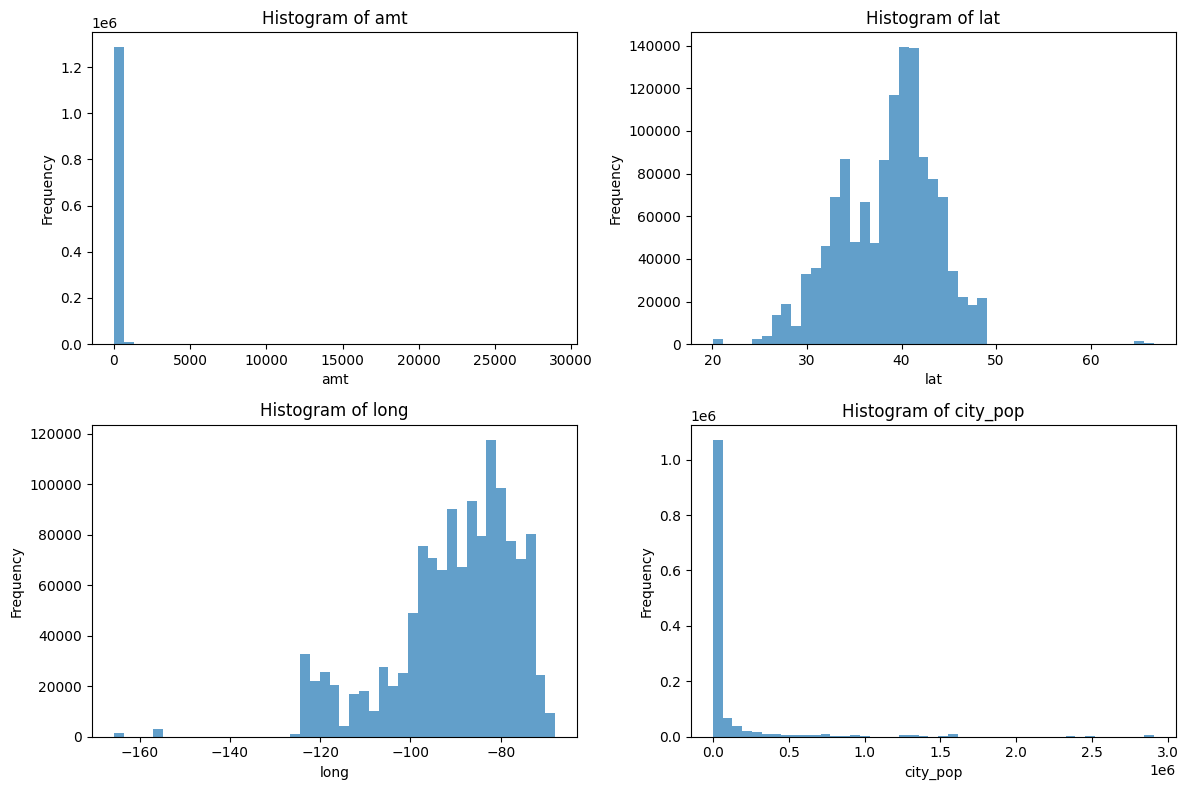

In [214]:
# Numerical columns for histograms
numerical_columns = ['amt', 'lat', 'long', 'city_pop']

# Create a figure and axes for subplots
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(12, 8))

# Flatten the axes array for easy iteration
axs = axs.flatten()

# Plot histograms for each numerical column
for i, col in enumerate(numerical_columns):
    ax = axs[i]
    ax.hist(df[col], bins=45, alpha=0.7)
    ax.set_title(f'Histogram of {col}')
    ax.set_xlabel(col)
    ax.set_ylabel('Frequency')

# Adjust layout and show plot
plt.tight_layout()
plt.show()

The graphs above show that there is a significant Data skewness where the data is highly skewed towards lower values of transactions and lower values of populations. In order to understand more we need to perform additional analysis with other EDA Techniques such as statistical summaries, box plots etc.


#### Step 3.2: Box plots for numerical columns

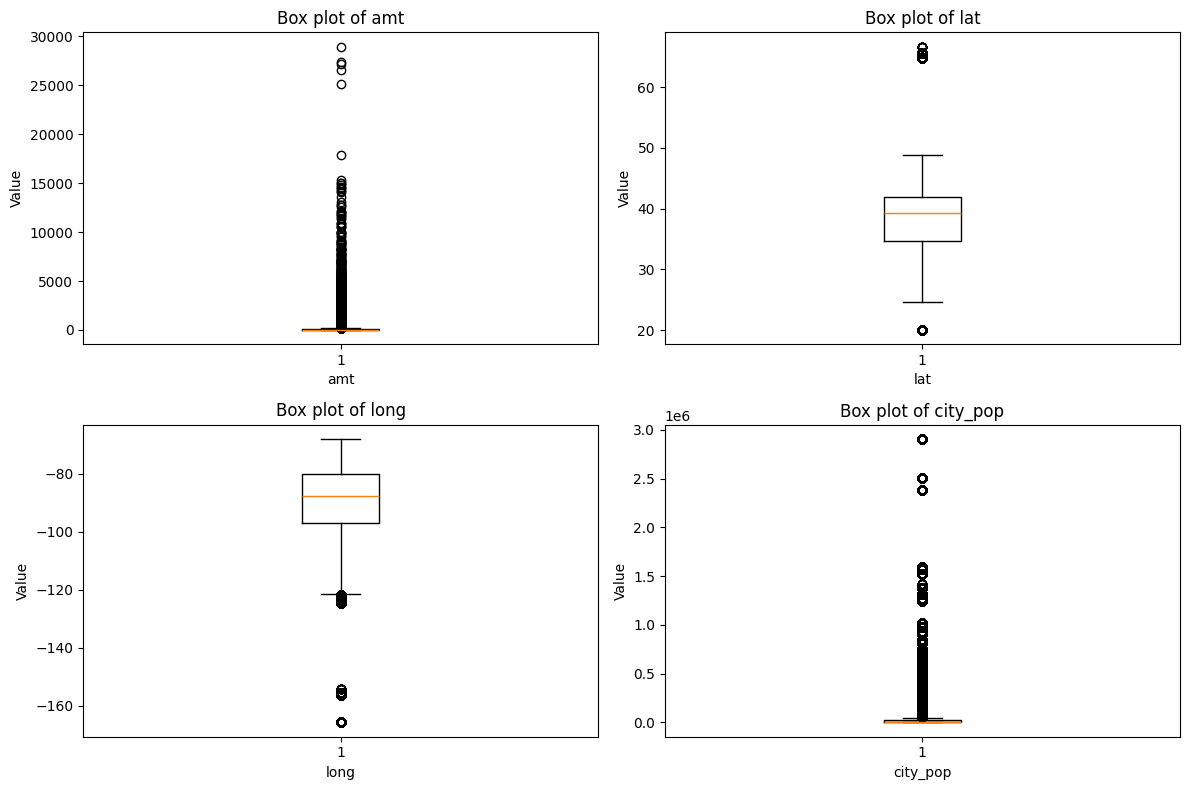

In [215]:
# Create a figure and axes for subplots
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(12, 8))

# Flatten the axes array for easy iteration
axs = axs.flatten()

# Plot box plots for each numerical column
for i, col in enumerate(numerical_columns):
    ax = axs[i]
    ax.boxplot(df[col])
    ax.set_title(f'Box plot of {col}')
    ax.set_xlabel(col)
    ax.set_ylabel('Value')

# Adjust layout and show plot
plt.tight_layout()
plt.show()

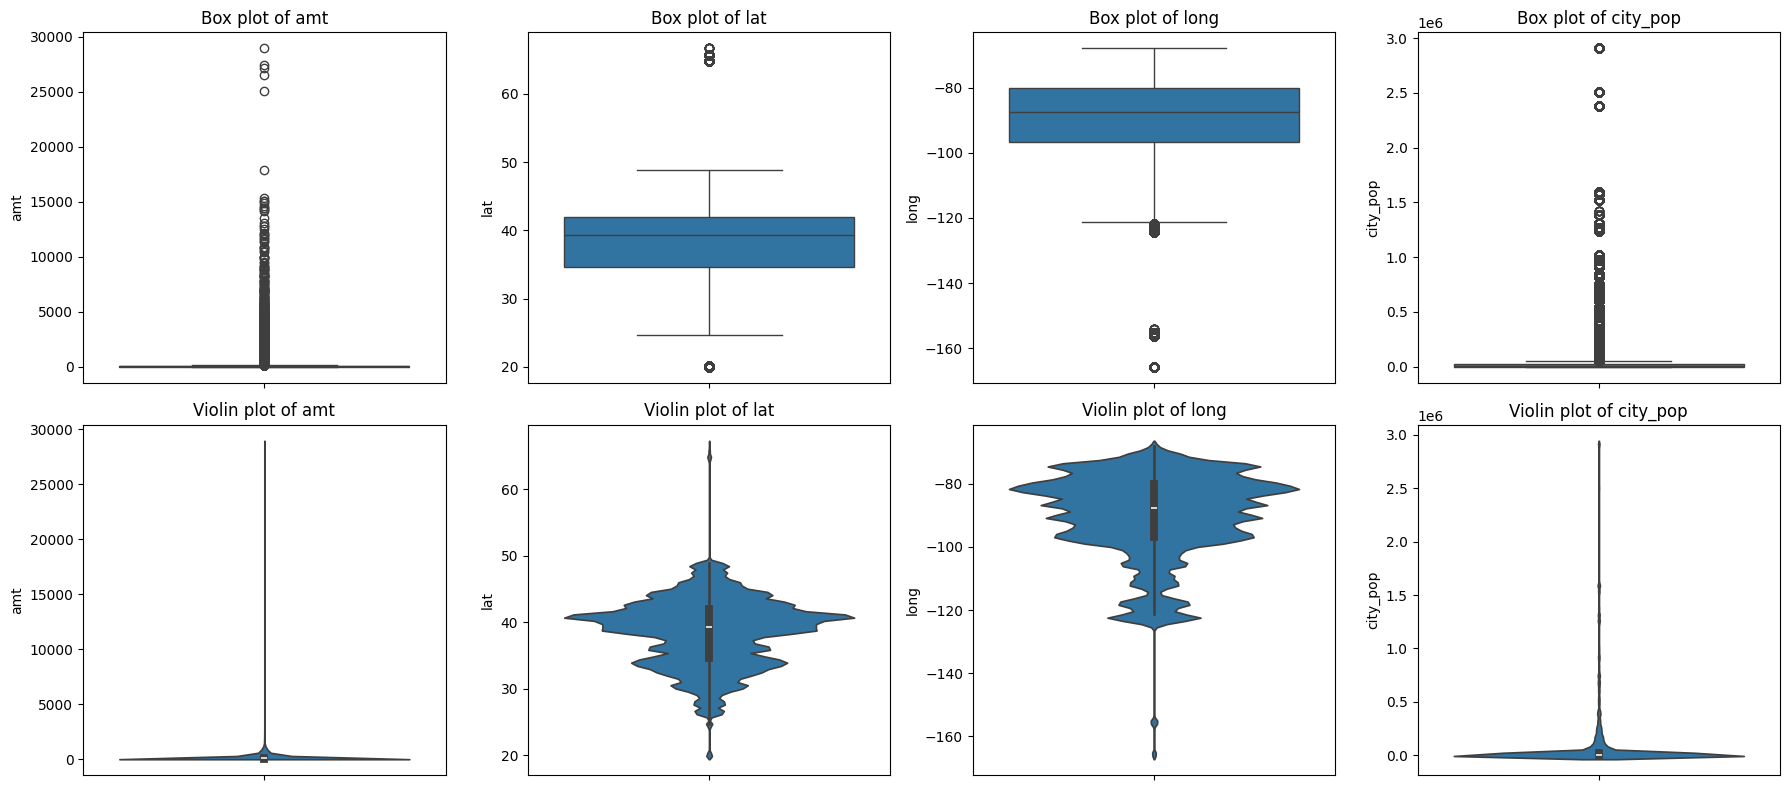

In [216]:
# Numerical columns for box and violin plots
numerical_columns = ['amt', 'lat', 'long', 'city_pop']

# Create a figure and axes for subplots
fig, axs = plt.subplots(nrows=2, ncols=4, figsize=(18, 8))

# Plot box plots and violin plots for each numerical column
for i, col in enumerate(numerical_columns):
    # Box plot
    sns.boxplot(y=df[col], ax=axs[0, i])
    axs[0, i].set_title(f'Box plot of {col}')
    axs[0, i].set_ylabel(col)
    
    # Violin plot
    sns.violinplot(y=df_test_test[col], ax=axs[1, i])
    axs[1, i].set_title(f'Violin plot of {col}')
    axs[1, i].set_ylabel(col)

# Adjust layout and show plot
plt.tight_layout()
plt.show()

#### 3.3 Bar Plots for Categorical Columns

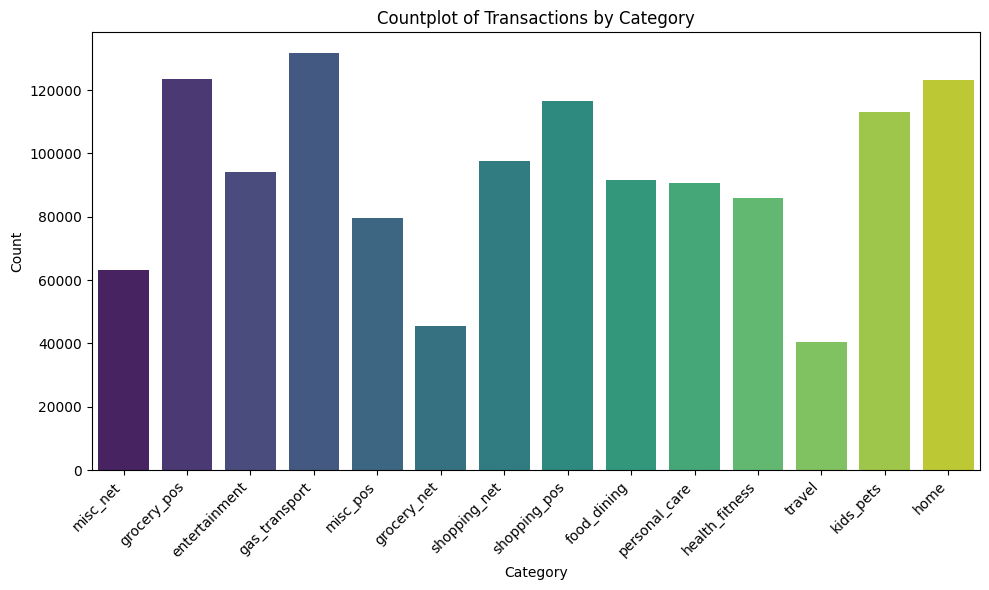

In [217]:
df['category'] = df['category'].astype(str)

# Create the countplot with hue
plt.figure(figsize=(10, 6))
ax = sns.countplot(x='category', data=df, palette='viridis')
ax.set_title('Countplot of Transactions by Category')
ax.set_xlabel('Category')
ax.set_ylabel('Count')

# Rotate x-axis ticks at a 45-degree angle for better visibility
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')

# Show plot
plt.tight_layout()
plt.show()

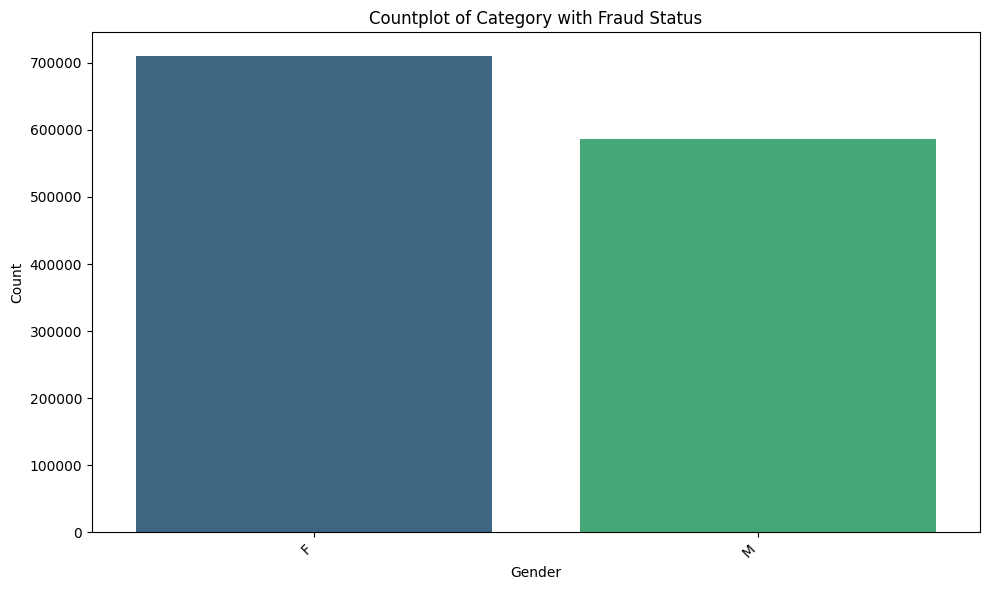

In [218]:
# Create the countplot with hue
plt.figure(figsize=(10, 6))
ax = sns.countplot(x='gender', data=df, palette='viridis')
ax.set_title('Countplot of Category with Fraud Status')
ax.set_xlabel('Gender')
ax.set_ylabel('Count')

# Rotate x-axis ticks at a 45-degree angle for better visibility
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')

# Show plot
plt.tight_layout()
plt.show()

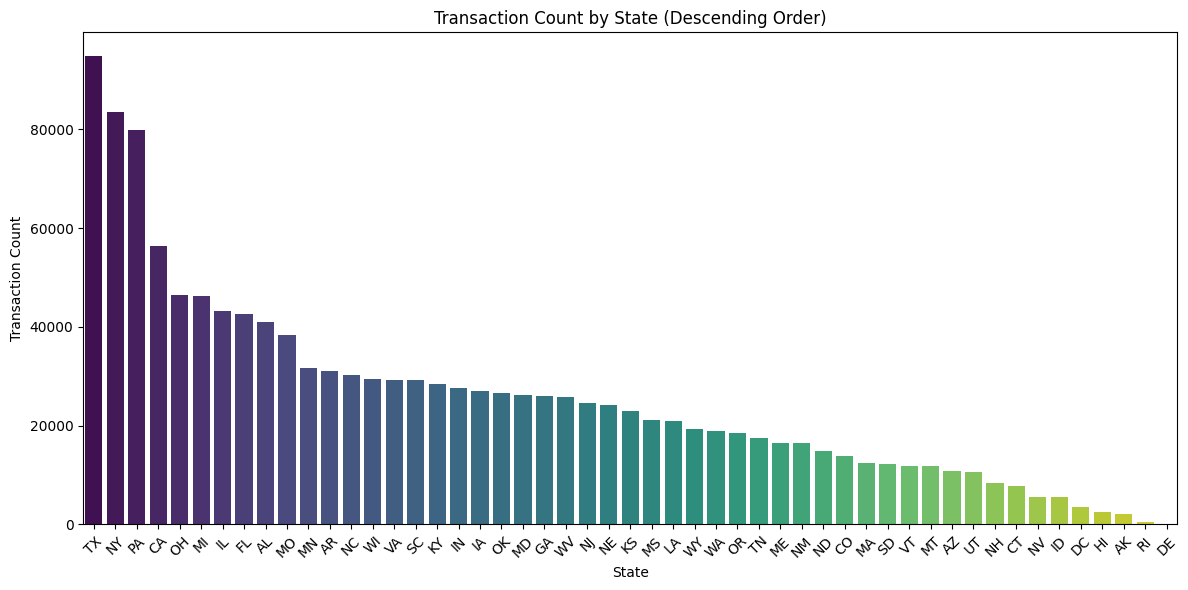

In [219]:
# Calculate the count of transactions by state
state_counts = df['state'].value_counts()

# Sort states based on transaction count (descending order)
sorted_states_desc = state_counts.sort_values(ascending=False)

# Create a count plot with seaborn
plt.figure(figsize=(12, 6))
sns.countplot(x='state', data=df, order=sorted_states_desc.index, palette='viridis')
plt.title('Transaction Count by State (Descending Order)')
plt.xlabel('State')
plt.ylabel('Transaction Count')
plt.xticks(rotation=45)  # Rotate x-axis labels for better visibility
plt.tight_layout()
plt.show()

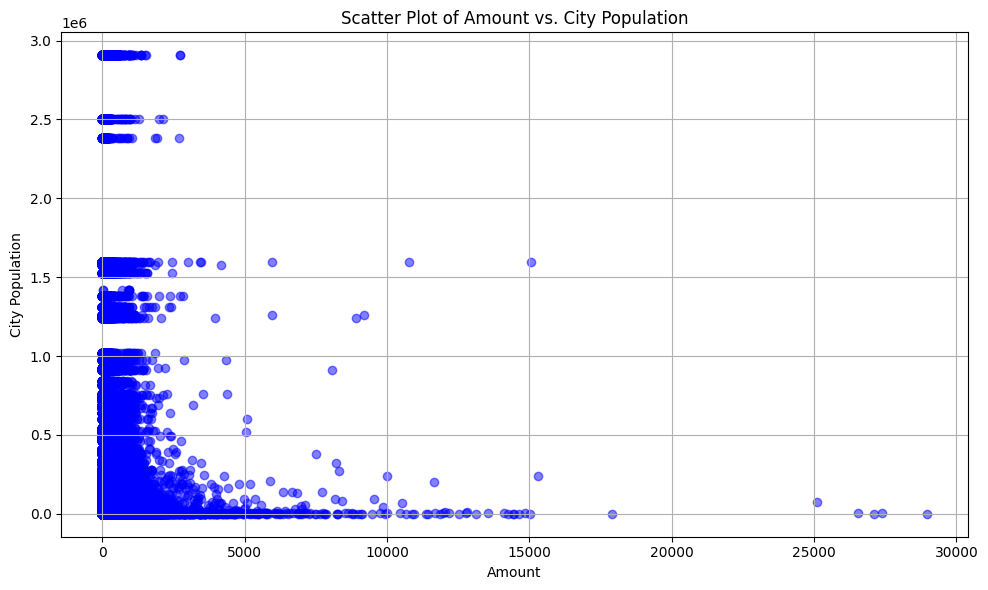

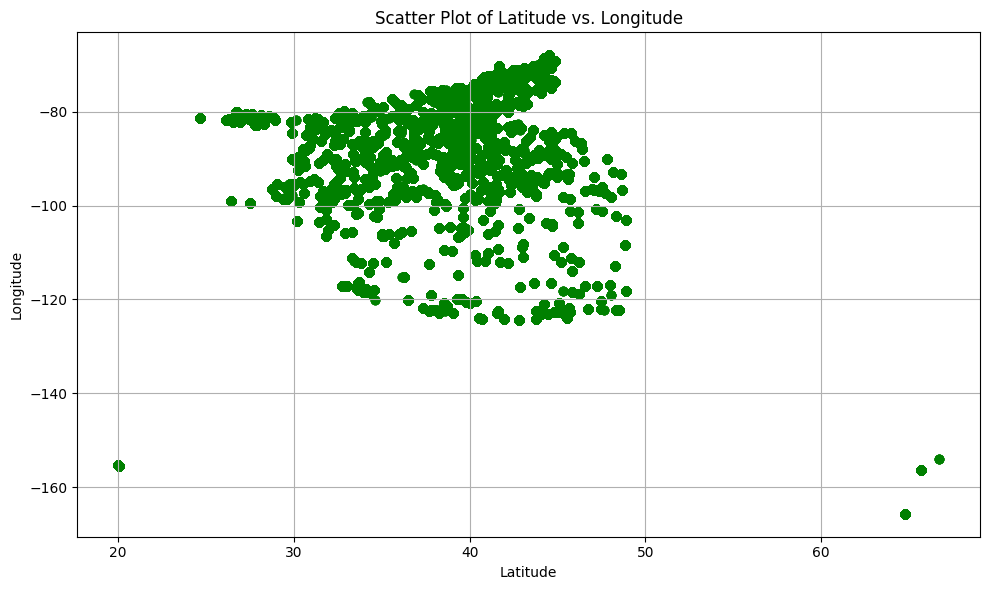

In [220]:
# Scatter plot of 'amt' vs. 'city_pop'

plt.figure(figsize=(10, 6))
plt.scatter(df['amt'], df['city_pop'], alpha=0.5, c='blue')
plt.title('Scatter Plot of Amount vs. City Population')
plt.xlabel('Amount')
plt.ylabel('City Population')
plt.grid(True)
plt.tight_layout()
plt.show()

# Scatter plot of 'lat' vs. 'long'
plt.figure(figsize=(10, 6))
plt.scatter(df['lat'], df['long'], alpha=0.5, c='green')
plt.title('Scatter Plot of Latitude vs. Longitude')
plt.xlabel('Latitude')
plt.ylabel('Longitude')
plt.grid(True)
plt.tight_layout()
plt.show()

### Step 4: Time Analysis

In [221]:
# Convert 'trans_date_trans_time' column to datetime format
df['trans_date_trans_time'] = pd.to_datetime(df['trans_date_trans_time'])

# Extract date features
df['day_of_week'] = df['trans_date_trans_time'].dt.day_name()
df['month'] = df['trans_date_trans_time'].dt.month
df['hour'] = df['trans_date_trans_time'].dt.hour

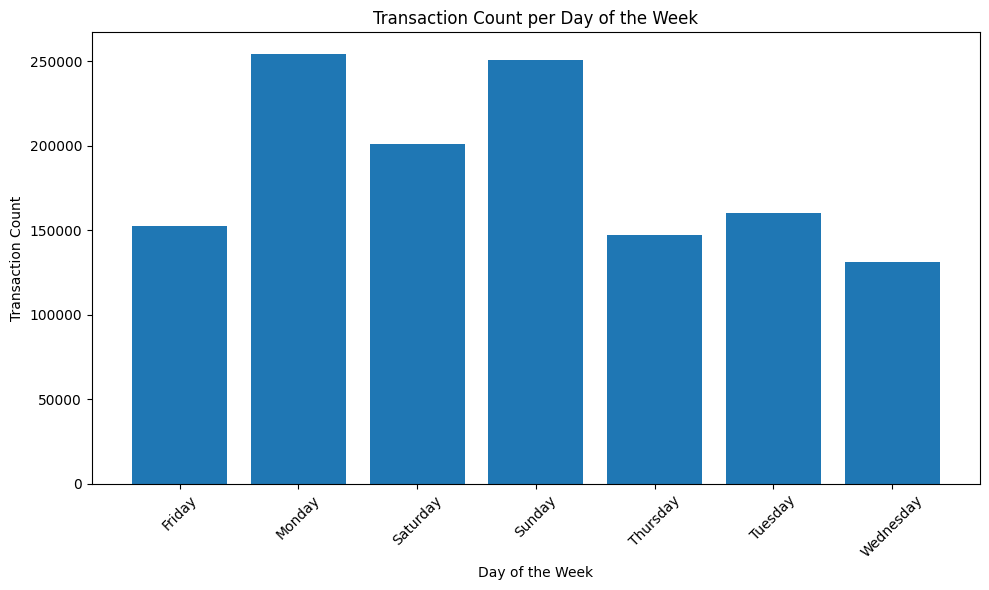

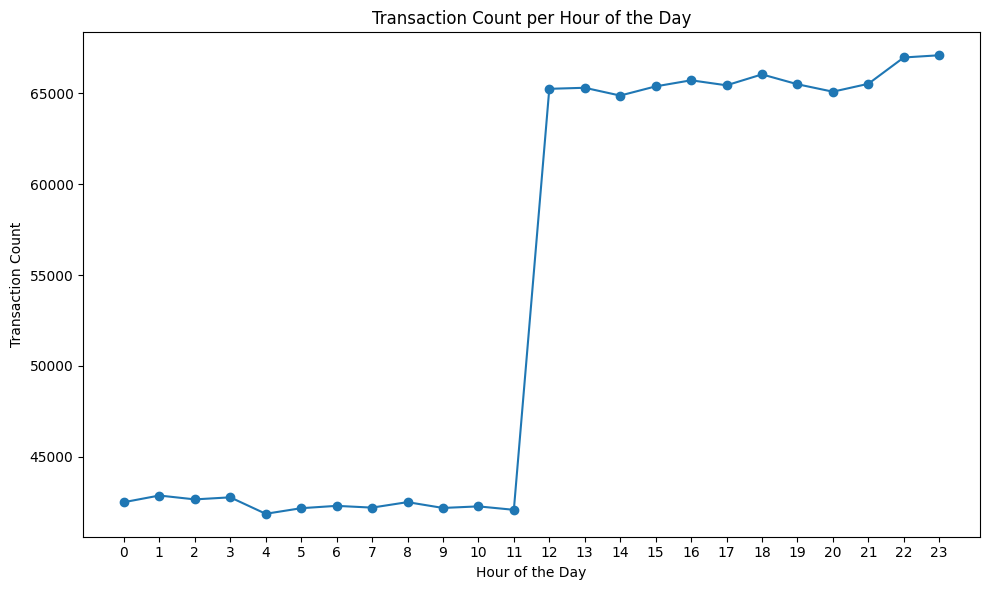

In [222]:
# Example: Analyze transaction count per day of the week
transaction_count_per_day = df.groupby('day_of_week').size().reset_index(name='transaction_count')

# Plot transaction count per day of the week
plt.figure(figsize=(10, 6))
plt.bar(transaction_count_per_day['day_of_week'], transaction_count_per_day['transaction_count'])
plt.title('Transaction Count per Day of the Week')
plt.xlabel('Day of the Week')
plt.ylabel('Transaction Count')
plt.xticks(rotation=45)  # Rotate x-axis labels for better visibility
plt.tight_layout()
plt.show()

# Example: Analyze transaction count per hour of the day
transaction_count_per_hour = df.groupby('hour').size().reset_index(name='transaction_count')

# Plot transaction count per hour of the day
plt.figure(figsize=(10, 6))
plt.plot(transaction_count_per_hour['hour'], transaction_count_per_hour['transaction_count'], marker='o')
plt.title('Transaction Count per Hour of the Day')
plt.xlabel('Hour of the Day')
plt.ylabel('Transaction Count')
plt.xticks(transaction_count_per_hour['hour'])
plt.tight_layout()
plt.show()

### Step 5: Fraud Analysis

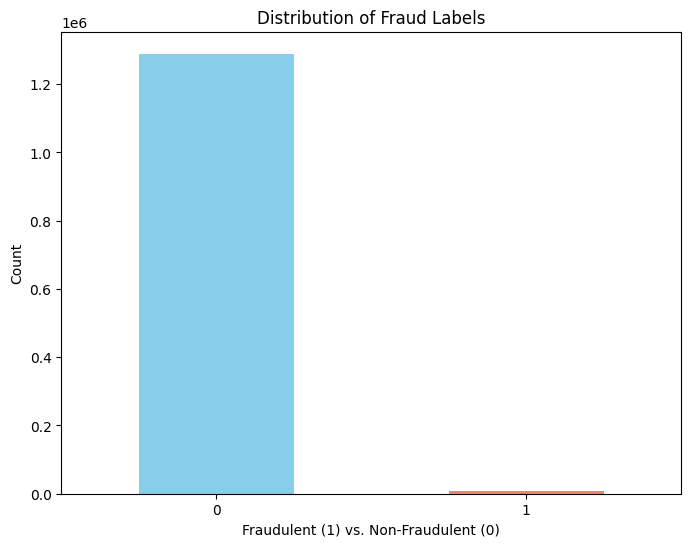

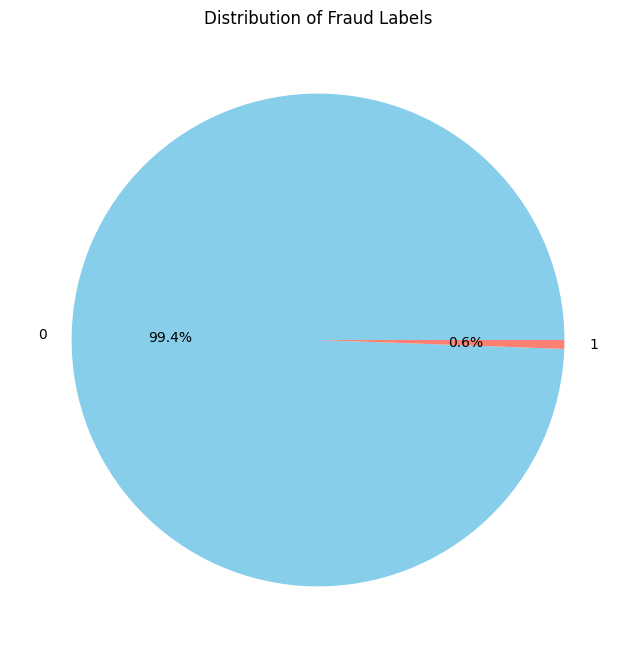

In [223]:
# Calculate the count of fraudulent and non-fraudulent transactions
fraud_counts = df['is_fraud'].value_counts()

# Plot the distribution using a bar plot
plt.figure(figsize=(8, 6))
fraud_counts.plot(kind='bar', color=['skyblue', 'salmon'])
plt.title('Distribution of Fraud Labels')
plt.xlabel('Fraudulent (1) vs. Non-Fraudulent (0)')
plt.ylabel('Count')
plt.xticks(rotation=0)  # Rotate x-axis labels if needed
plt.show()

# Plot the distribution using a pie chart
plt.figure(figsize=(8, 8))
plt.pie(fraud_counts, labels=fraud_counts.index, autopct='%1.1f%%', colors=['skyblue', 'salmon'])
plt.title('Distribution of Fraud Labels')
plt.show()

# Calculate the percentage of fraudulent transactions
fraud_percentage = fraud_counts[1] / len(df) * 100
non_fraud_percentage = fraud_counts[0] / len(df) * 100

As we can see from above, the data is highly imbalanced with only 0.6% of transactions to be fradulant among 1.2 million transactions

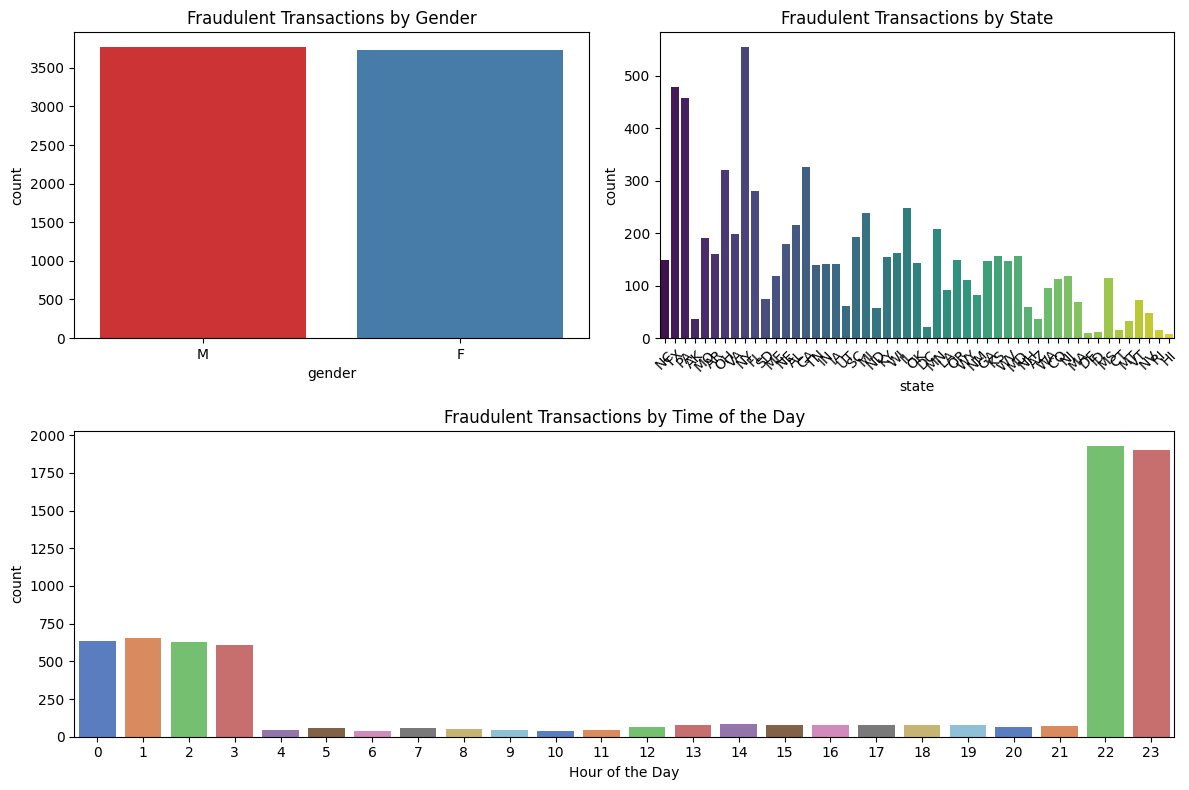

In [224]:
# Filter DataFrame for fraudulent transactions
fraudulent_df = df[df['is_fraud'] == 1]

# Set the figure size
plt.figure(figsize=(12, 8))

# Plot 1: Determine fraud transactions by gender
plt.subplot(2, 2, 1)
sns.countplot(x='gender', data=fraudulent_df, palette='Set1')
plt.title('Fraudulent Transactions by Gender')

# Plot 2: Determine fraud transactions by state
plt.subplot(2, 2, 2)
sns.countplot(x='state', data=fraudulent_df, palette='viridis')
plt.title('Fraudulent Transactions by State')
plt.xticks(rotation=45)  # Rotate x-axis labels for better visibility

# Extract hour of the day from datetime column for time-based analysis
fraudulent_df['hour'] = fraudulent_df['trans_date_trans_time'].dt.hour

# Plot 3: Determine fraud transactions by time of the day
plt.subplot(2, 1, 2)
sns.countplot(x='hour', data=fraudulent_df, palette='muted')
plt.title('Fraudulent Transactions by Time of the Day')
plt.xlabel('Hour of the Day')

# Adjust layout and show plots
plt.tight_layout()
plt.show()

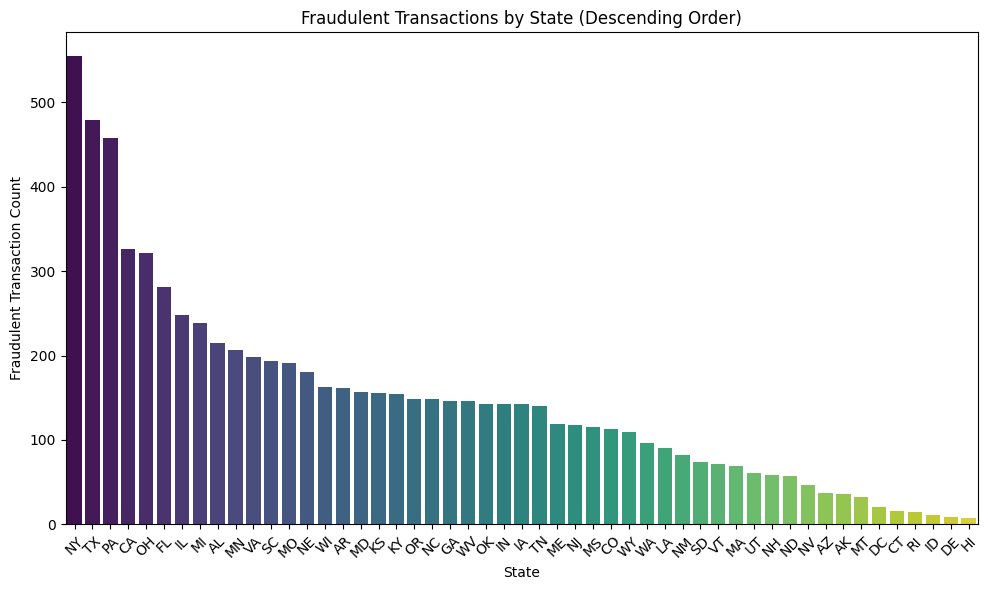

In [225]:
# Calculate the count of fraudulent transactions per state and sort in descending order
fraudulent_state_counts = fraudulent_df['state'].value_counts().sort_values(ascending=False)

# Set the figure size
plt.figure(figsize=(10, 6))

# Plot fraudulent transactions by state in descending order
sns.countplot(x='state', data=fraudulent_df, order=fraudulent_state_counts.index, palette='viridis')
plt.title('Fraudulent Transactions by State (Descending Order)')
plt.xlabel('State')
plt.ylabel('Fraudulent Transaction Count')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

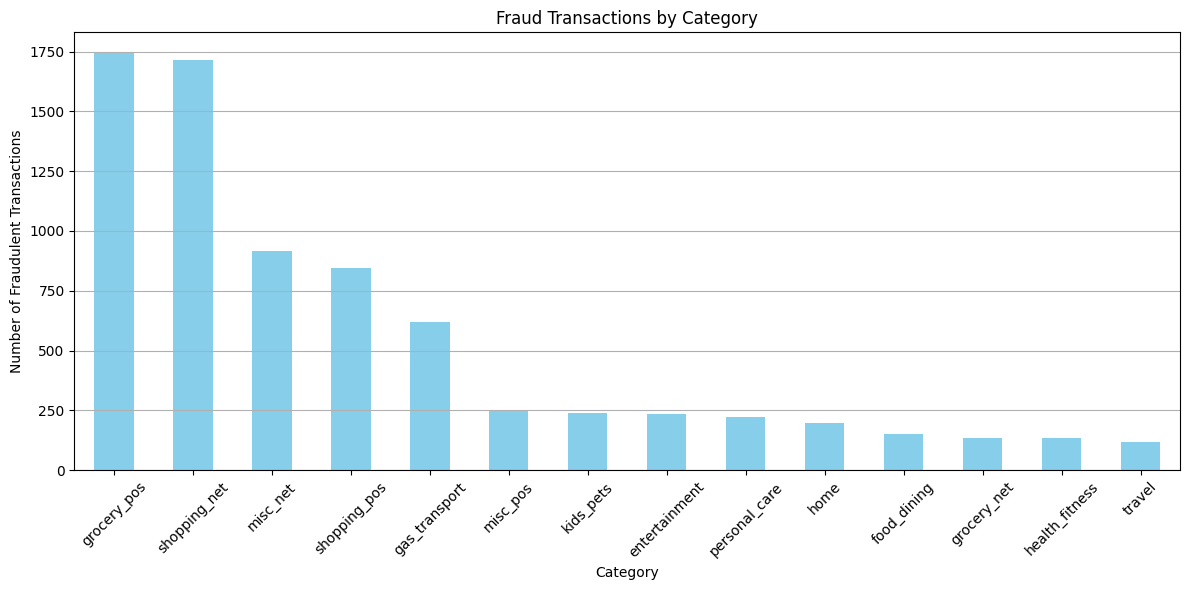

In [226]:
# Calculate the count of fraudulent transactions by category
fraudulent_category_counts = fraudulent_df['category'].value_counts()

# Plot bar graph of fraud transactions by category
plt.figure(figsize=(12, 6))
fraudulent_category_counts.plot(kind='bar', color='skyblue')
plt.title('Fraud Transactions by Category')
plt.xlabel('Category')
plt.ylabel('Number of Fraudulent Transactions')
plt.xticks(rotation=45)  # Rotate x-axis labels for better visibility
plt.grid(axis='y')  # Add grid lines on y-axis for clarity
plt.tight_layout()
plt.show()

From the above graphs, we can notice that: 
1. Most fraud transactions appear to be happening in the middle of the night.
2. Fradulant transactions appear to be the highest in NY state followed by TX and PA. 
3. Other states have an average fraud rate with HI being the lowest.
4. Highest number of fraud transactions are in grocery_pos and shopping net

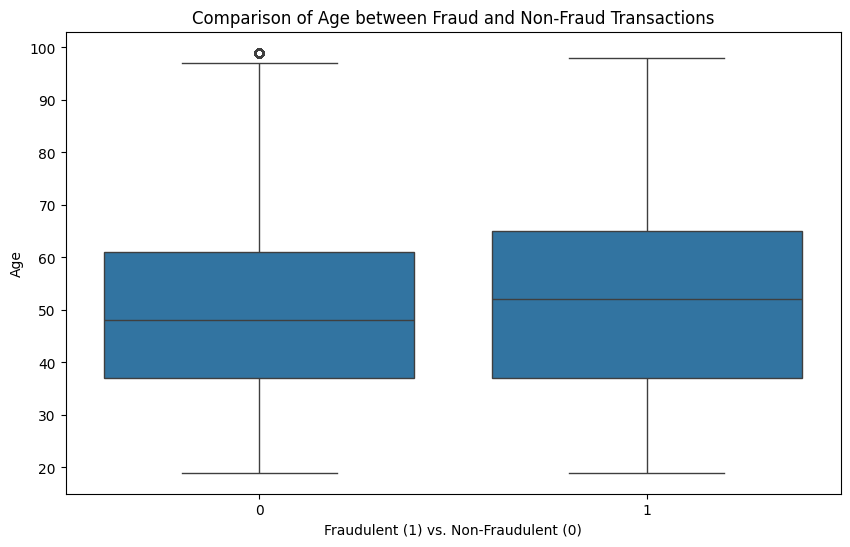

In [227]:
# Convert 'dob' column to datetime format
df['dob'] = pd.to_datetime(df['dob'])

# Calculate age from date of birth
current_date = datetime.now()
df['age'] = (current_date - df['dob']).dt.days // 365  # Calculate age in years

# Analyze distribution of age for fraud vs. non-fraud transactions
plt.figure(figsize=(10, 6))
sns.boxplot(x='is_fraud', y='age', data=df)
plt.title('Comparison of Age between Fraud and Non-Fraud Transactions')
plt.xlabel('Fraudulent (1) vs. Non-Fraudulent (0)')
plt.ylabel('Age')
plt.show()

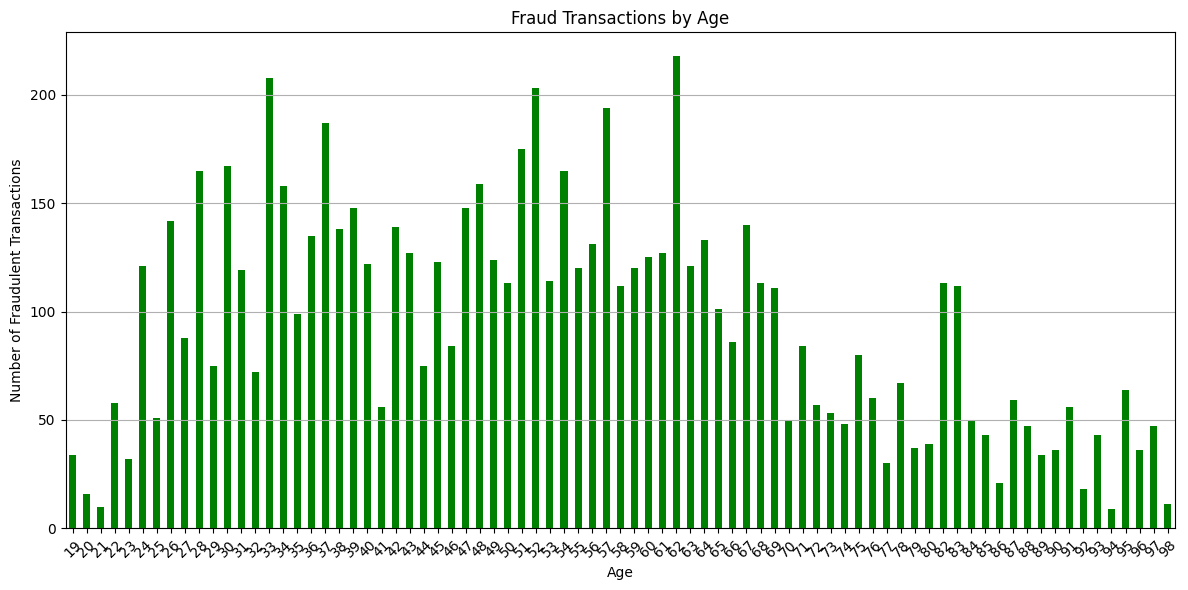

In [228]:
# Convert 'dob' column to datetime format
fraudulent_df['dob'] = pd.to_datetime(fraudulent_df['dob'])

# Calculate age from date of birth
current_date = datetime.now()
fraudulent_df['age'] = (current_date - fraudulent_df['dob']).dt.days // 365

# Calculate the count of fraudulent transactions by age
fraudulent_age_counts = fraudulent_df['age'].value_counts().sort_index()

# Plot bar graph of fraud transactions by age
plt.figure(figsize=(12, 6))
fraudulent_age_counts.plot(kind='bar', color='green')
plt.title('Fraud Transactions by Age')
plt.xlabel('Age')
plt.ylabel('Number of Fraudulent Transactions')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.tight_layout()
plt.show()

### Step 6: Correlation analysis.

In [229]:
# Bringing the original data set again to make sure our modeling is done on the unaltered dataset. 
df = pd.read_csv('./data/fraudTrain.csv')

#### Step 6.1 Add back Age and Transaction Hour columns.

In [230]:
# Get hour from trans_date_trans_time column as we noticed that hour of the day had significant impact on fraud transactions.
df['transaction_hour'] = pd.to_datetime(df['trans_date_trans_time'],format="%Y-%m-%d %H:%M:%S").dt.hour

# Also we noticed that age plays a role in determining fraud transactions. Hence adding age to the dataaset, derived from dob.

### Add Age to data set by calculating it  from date of birth
current_date = datetime.now()
df['age'] = (current_date - pd.to_datetime(df['dob'])).dt.days // 365
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1296675 entries, 0 to 1296674
Data columns (total 25 columns):
 #   Column                 Non-Null Count    Dtype  
---  ------                 --------------    -----  
 0   Unnamed: 0             1296675 non-null  int64  
 1   trans_date_trans_time  1296675 non-null  object 
 2   cc_num                 1296675 non-null  int64  
 3   merchant               1296675 non-null  object 
 4   category               1296675 non-null  object 
 5   amt                    1296675 non-null  float64
 6   first                  1296675 non-null  object 
 7   last                   1296675 non-null  object 
 8   gender                 1296675 non-null  object 
 9   street                 1296675 non-null  object 
 10  city                   1296675 non-null  object 
 11  state                  1296675 non-null  object 
 12  zip                    1296675 non-null  int64  
 13  lat                    1296675 non-null  float64
 14  long              

#### Step 6.2: Drop likely irrelevant columns

Most object columns that do not fit into categorical classifications are unlikely to significantly influence fraud detection based solely on their values. Thus, it is prudent to exclude these columns and focus on identifying correlations among potential contributing factors, as well as determining their relative importance in fraud detection analysis.

In [231]:
# Drop columns based on analysis and domain knowledge
columns_to_drop = ['Unnamed: 0', 'trans_date_trans_time', 'cc_num', 'merchant', 'first', 'last', 'street', 
                    'zip', 'dob', 'trans_num', 'unix_time', 'city_pop']

# Drop the columns from the DataFrame
df_processed = df.drop(columns=columns_to_drop)

# Display the processed DataFrame
df_processed.head()

,category,amt,gender,city,state,lat,long,job,merch_lat,merch_long,is_fraud,transaction_hour,age
0,misc_net,4.97,F,Moravian Falls,NC,36.0788,-81.1781,"Psychologist, counselling",36.011293,-82.048315,0,0,36
1,grocery_pos,107.23,F,Orient,WA,48.8878,-118.2105,Special educational needs teacher,49.159047,-118.186462,0,0,45
2,entertainment,220.11,M,Malad City,ID,42.1808,-112.2620,Nature conservation officer,43.150704,-112.154481,0,0,62
3,gas_transport,45.00,M,Boulder,MT,46.2306,-112.1138,Patent attorney,47.034331,-112.561071,0,0,57
4,misc_pos,41.96,M,Doe Hill,VA,38.4207,-79.4629,Dance movement psychotherapist,38.674999,-78.632459,0,0,38


In [232]:
df_processed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1296675 entries, 0 to 1296674
Data columns (total 13 columns):
 #   Column            Non-Null Count    Dtype  
---  ------            --------------    -----  
 0   category          1296675 non-null  object 
 1   amt               1296675 non-null  float64
 2   gender            1296675 non-null  object 
 3   city              1296675 non-null  object 
 4   state             1296675 non-null  object 
 5   lat               1296675 non-null  float64
 6   long              1296675 non-null  float64
 7   job               1296675 non-null  object 
 8   merch_lat         1296675 non-null  float64
 9   merch_long        1296675 non-null  float64
 10  is_fraud          1296675 non-null  int64  
 11  transaction_hour  1296675 non-null  int32  
 12  age               1296675 non-null  int64  
dtypes: float64(5), int32(1), int64(2), object(5)
memory usage: 123.7+ MB


#### Step 6.3 Encode the data

In [233]:
X = df_processed.drop(['is_fraud'], axis=1)
y = df_processed['is_fraud']

X = ce.JamesSteinEncoder().fit_transform(X, y)
X.head()

,category,amt,gender,city,state,lat,long,job,merch_lat,merch_long,transaction_hour,age
0,0.009233,4.97,0.005262,0.00000,0.005305,36.0788,-81.1781,0.002619,36.011293,-82.048315,0,36
1,0.009126,107.23,0.005262,0.00000,0.005394,48.8878,-118.2105,0.003142,49.159047,-118.186462,0,45
2,0.003320,220.11,0.006426,0.00000,0.002919,42.1808,-112.2620,0.008497,43.150704,-112.154481,0,62
3,0.005109,45.00,0.006426,0.00985,0.003666,46.2306,-112.1138,0.006689,47.034331,-112.561071,0,57
4,0.003928,41.96,0.006426,0.00000,0.006262,38.4207,-79.4629,0.000000,38.674999,-78.632459,0,38


#### Step 6.4 Get Feature Importances and correlation

Feature Importance:
             Feature  Importance
1                amt    0.361018
0           category    0.171630
10  transaction_hour    0.119137
3               city    0.094701
11               age    0.065576
9         merch_long    0.046356
8          merch_lat    0.046176
7                job    0.037532
5                lat    0.017163
6               long    0.016269
4              state    0.012657
2             gender    0.011784


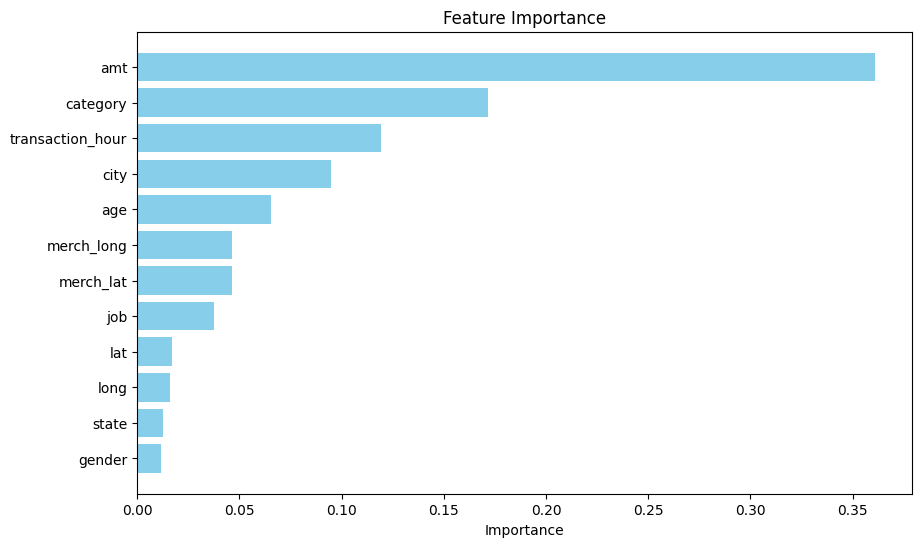

In [234]:
# Initialize RandomForestClassifier
rf_classifier = RandomForestClassifier()

# Fit the model to the data
rf_classifier.fit(X, y)

# Get feature importances
feature_importances = rf_classifier.feature_importances_

# Create a DataFrame to store feature importance scores
feature_importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': feature_importances})

# Sort features by importance
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Display feature importance
print("Feature Importance:")
print(feature_importance_df)

# Plot feature importance as a bar graph
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.title('Feature Importance')
plt.gca().invert_yaxis()  # Invert y-axis to show most important features at the top
plt.show()

The above graph shows that amount has significant importance when determining which transaction could be a fraud one. Followed by category, hour and age.

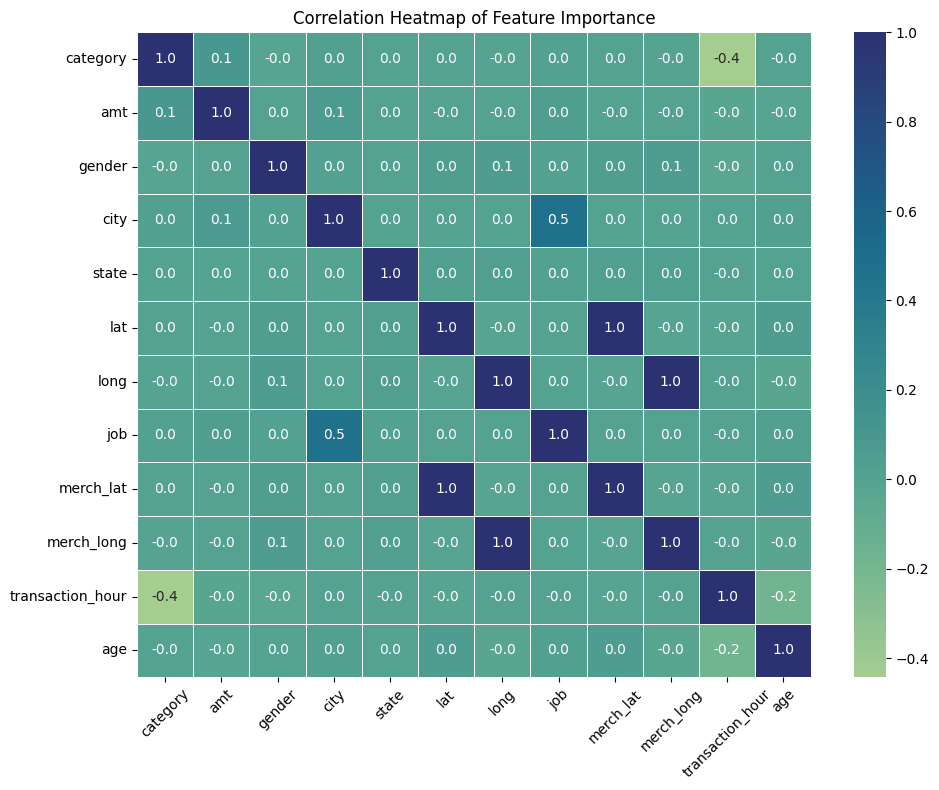

In [235]:
corr_matrix = X.corr()

# Plot heatmap using seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(X.corr(),annot=True,fmt='.1f',linewidth=.5,cmap="crest")
plt.title('Correlation Heatmap of Feature Importance')
plt.xticks(rotation=45)  # Rotate x-axis labels for better visibility
plt.yticks(rotation=0)  # Keep y-axis labels horizontal
plt.tight_layout()
plt.show()

#### Step 6.5 Scale Data

In [236]:
# Apply Standard scalar on the data as it is needed for all modeling techniques. 
X = StandardScaler().fit_transform(X)

In [237]:
# Dictionary to store results
model_results = {
    'Accuracy': {},
    'Precision': {},
    'Recall': {},
    'F1 Score': {},
    'ROC-AUC': {}
}

#### Check to see if stratification makes any difference.

In [336]:
X_train,X_test,y_train,y_test =  train_test_split(X,y,test_size=0.3, random_state=42)
train_data = pd.concat([ pd.DataFrame(X_train), y_train], axis=1)
train_data.head()
train_data["is_fraud"].value_counts()

is_fraud
0.0    387498
1.0      1505
Name: count, dtype: int64

In [337]:
X_train_strat, X_test_strat, y_train_strat, y_test_strat = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)
train_strat_data = pd.concat([ pd.DataFrame(X_train_strat), y_train_strat], axis=1)
train_strat_data.head()
train_strat_data["is_fraud"].value_counts()

is_fraud
0.0    387502
1.0      1501
Name: count, dtype: int64

Stratification didn't help much probably due to a lot of reasons such as:

**Random Split**: If we don't use Startification, the train-test split is random. While it tries to pick random samples, there's no guarantee it will perfectly reflect the original data's class balance. In this case, it might have just happened to select slightly more fraudulent transactions for the non-stratified test set due to randomness.

**Sample Size**: The impact of stratification becomes more significant with smaller datasets. Since the dataset is relatively large, a small difference (20 samples) might not be a substantial deviation from the original distribution, even in the non-stratified split.

**Class Imbalance**: The severity of imbalanced data also plays a role. If the number of fraudulent transactions is very low compared to legitimate ones (highly imbalanced), even a small difference in the test set can be significant proportionally.

Having said that, stratification will not be used in the splits for training our models.

### Step 7. Training the models

In [344]:
# Generic modeling method with and without hyper parameters

def train_model_and_predict(X_train, X_test, y_train, y_test, model, name, params=None, optimal_threshold=0.1):
    
    # Train the model with or without hyperparameter tuning
    if params is not None:
        grid_search = GridSearchCV(model, param_grid=params, n_jobs=-1, verbose=3, scoring="accuracy")
        grid_search.fit(X_train, y_train)
        best_model = grid_search.best_estimator_
        print(f"Best {name} Model:", best_model)
    else:
        model.fit(X_train, y_train)
        best_model = model
        print(f"{name} Model:", best_model)

    # Cross-validation scores
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    cv_scores = cross_val_score(best_model, X_train, y_train, cv=cv, scoring='roc_auc')
    print(f"{name} Model Cross-validated ROC-AUC scores: {cv_scores}")
    print(f"Mean ROC-AUC: {cv_scores.mean():.4f}, Std Dev: {cv_scores.std():.4f}")


    # Predict on the test set
    y_pred = best_model.predict(X_test)
    y_prob = best_model.predict_proba(X_test)[:, 1]  # Probabilities for ROC-AUC
    
    # Adjust the classification threshold
    y_pred_adjusted = (y_prob >= optimal_threshold).astype(int)
    accuracy = accuracy_score(y_test, y_pred_adjusted)
    precision = precision_score(y_test, y_pred_adjusted)
    recall = recall_score(y_test, y_pred_adjusted)
    f1 = f1_score(y_test, y_pred_adjusted)
    roc_auc = roc_auc_score(y_test, y_prob)
        
    # Print evaluation metrics
    print(f"{name} Model Evaluation:")
    print(f"Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}")
    print(f"ROC-AUC: {roc_auc:.4f}")
    
    model_results['Accuracy'][name] = accuracy
    model_results['Precision'][name] = precision
    model_results['Recall'][name] = recall
    model_results['F1 Score'][name] = f1
    model_results['ROC-AUC'][name] = roc_auc

    fig, axes = plt.subplots(1, 3, figsize=(18, 6))

    # Plot ROC-AUC curve
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    roc_auc = roc_auc_score(y_test, y_prob)
    axes[0].plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.2f})')
    axes[0].plot([0, 1], [0, 1], linestyle='--', color='grey', label='Chance')
    axes[0].set_title('ROC Curve')
    axes[0].set_xlabel('False Positive Rate')
    axes[0].set_ylabel('True Positive Rate')
    axes[0].legend()

    # Plot confusion matrix
    cm = confusion_matrix(y_test, y_pred_adjusted)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(ax=axes[1], colorbar=False)
    axes[1].set_title('Confusion Matrix')

    # Plot precision-recall curve
    precision, recall, _ = precision_recall_curve(y_test, y_prob)
    axes[2].plot(recall, precision)
    axes[2].set_title('Precision-Recall Curve')
    axes[2].set_xlabel('Recall')
    axes[2].set_ylabel('Precision')

    # Adjust layout
    plt.tight_layout()
    plt.show()
    
    # Print classification report
    print(f"Classification Report - {name} Model:")
    print(classification_report(y_test, y_pred_adjusted))
    
    return best_model

Base Model

Logistic Reg Model: LogisticRegression()
Logistic Reg Model Cross-validated ROC-AUC scores: [0.95286872 0.96303384 0.95976564 0.9568965  0.96912994]
Mean ROC-AUC: 0.9603, Std Dev: 0.0055


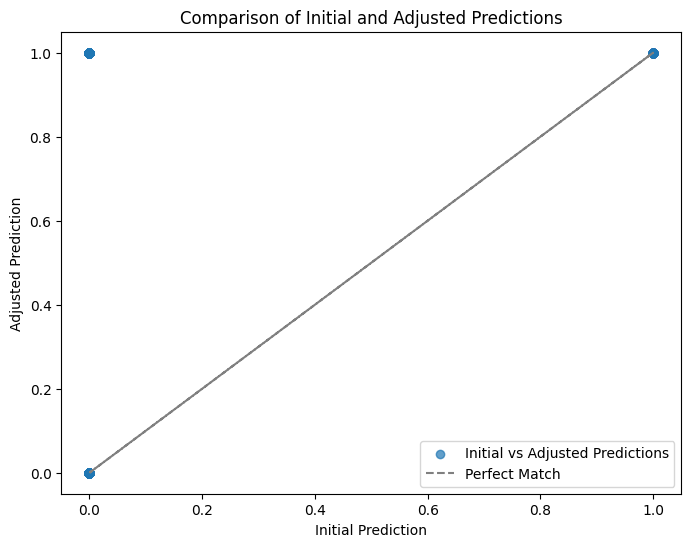

Agreement between Initial and Adjusted Predictions: 0.9970
Logistic Reg Model Evaluation:
Accuracy: 0.9958, Precision: 0.4469, Recall: 0.4406, F1 Score: 0.4437
ROC-AUC: 0.9636


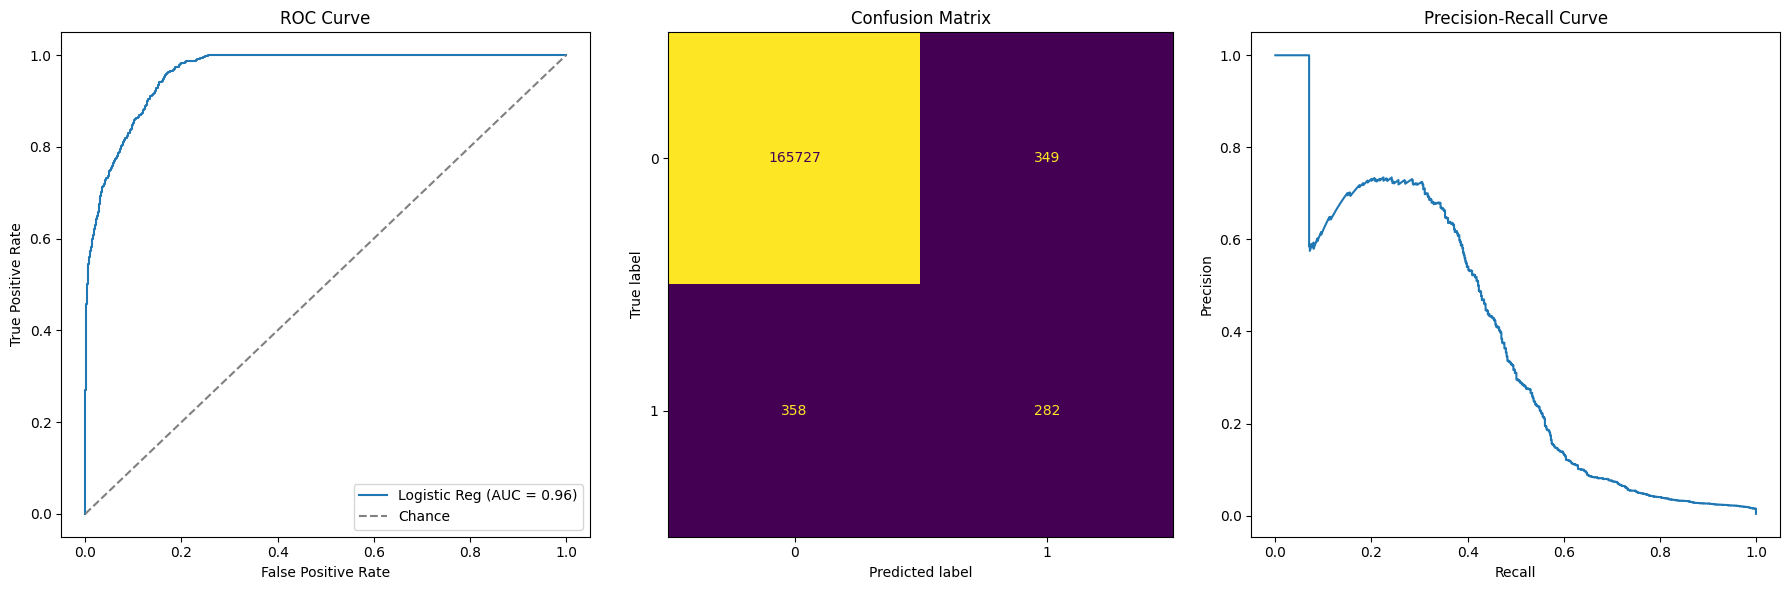

Classification Report - Logistic Reg Model:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    166076
           1       0.45      0.44      0.44       640

    accuracy                           1.00    166716
   macro avg       0.72      0.72      0.72    166716
weighted avg       1.00      1.00      1.00    166716



In [345]:
lrgModel = train_model_and_predict(X_train,X_test,y_train,y_test, LogisticRegression(), "Logistic Reg", None)

### Base model with hyperparameters

Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best LGR with Params Model: LogisticRegression(C=50, class_weight={0: 1, 1: 0.5}, max_iter=5000, n_jobs=-1)
LGR with Params Model Cross-validated ROC-AUC scores: [0.85051285 0.85458616 0.86009077 0.86112874 0.85328657]
Mean ROC-AUC: 0.8559, Std Dev: 0.0041
LGR with Params Model Evaluation:
Accuracy: 0.9947, Precision: 0.8788, Recall: 0.0901, F1 Score: 0.1635
ROC-AUC: 0.8593


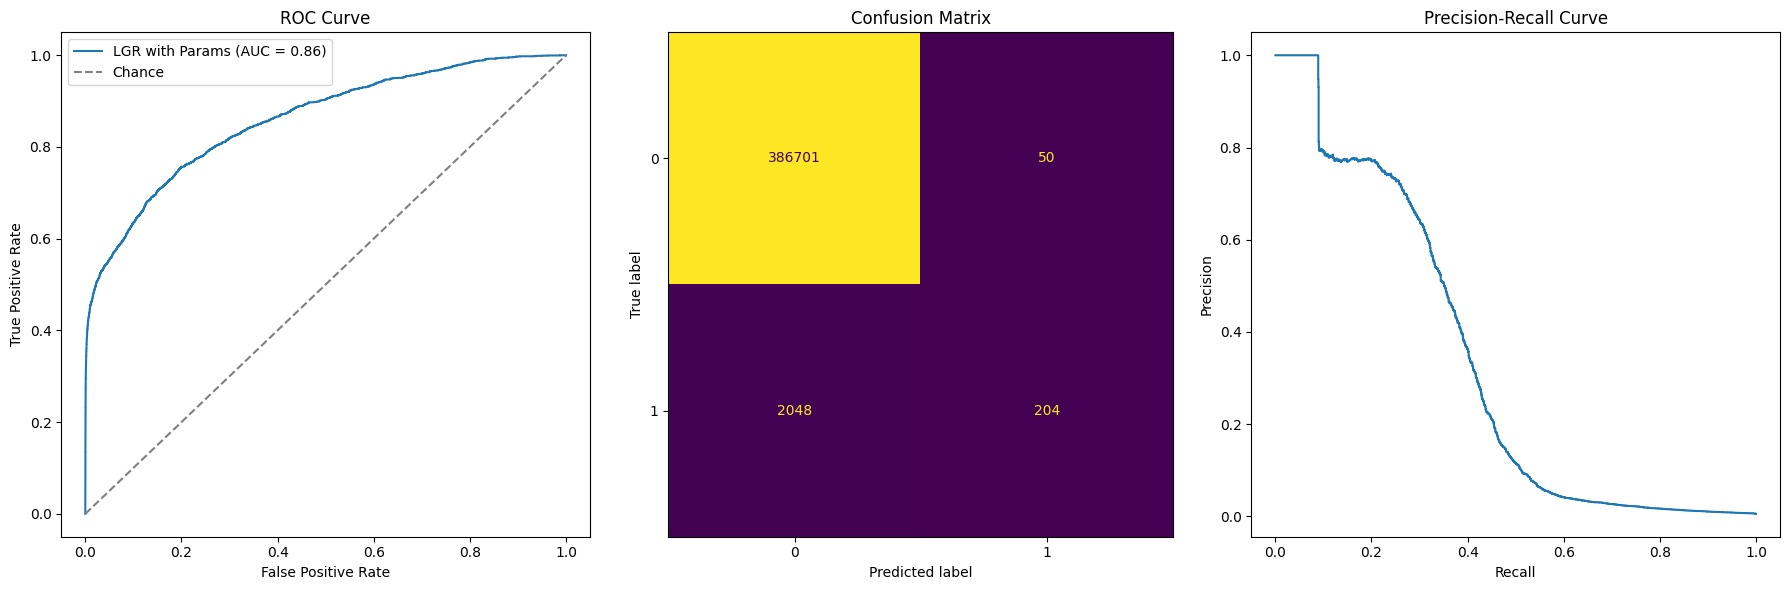

Classification Report - LGR with Params Model:
              precision    recall  f1-score   support

           0       0.99      1.00      1.00    386751
           1       0.80      0.09      0.16      2252

    accuracy                           0.99    389003
   macro avg       0.90      0.55      0.58    389003
weighted avg       0.99      0.99      0.99    389003



In [240]:
lgr_params = {
    "C": [10, 50],
    "max_iter": [5000, 10000],
    "class_weight": [{0: 1, 1: 0.5}, {0: 1, 1: 1}]
}
lgr_hyper_model = train_model_and_predict(X_train,X_test,y_train,y_test, LogisticRegression(n_jobs=-1), "LGR with Params", lgr_params)

### Training Other Models using above helper method.

### K Nearest Neighbors model with hyper parameters

Fitting 5 folds for each of 4 candidates, totalling 20 fits
Best KNN with Params Model: KNeighborsClassifier(n_jobs=-1, n_neighbors=3)
KNN with Params Model Cross-validated ROC-AUC scores: [0.87001622 0.85338273 0.86509924 0.86001632 0.87103393]
Mean ROC-AUC: 0.8639, Std Dev: 0.0066
KNN with Params Model Evaluation:
Accuracy: 0.9968, Precision: 0.9424, Recall: 0.4796, F1 Score: 0.6357
ROC-AUC: 0.8769


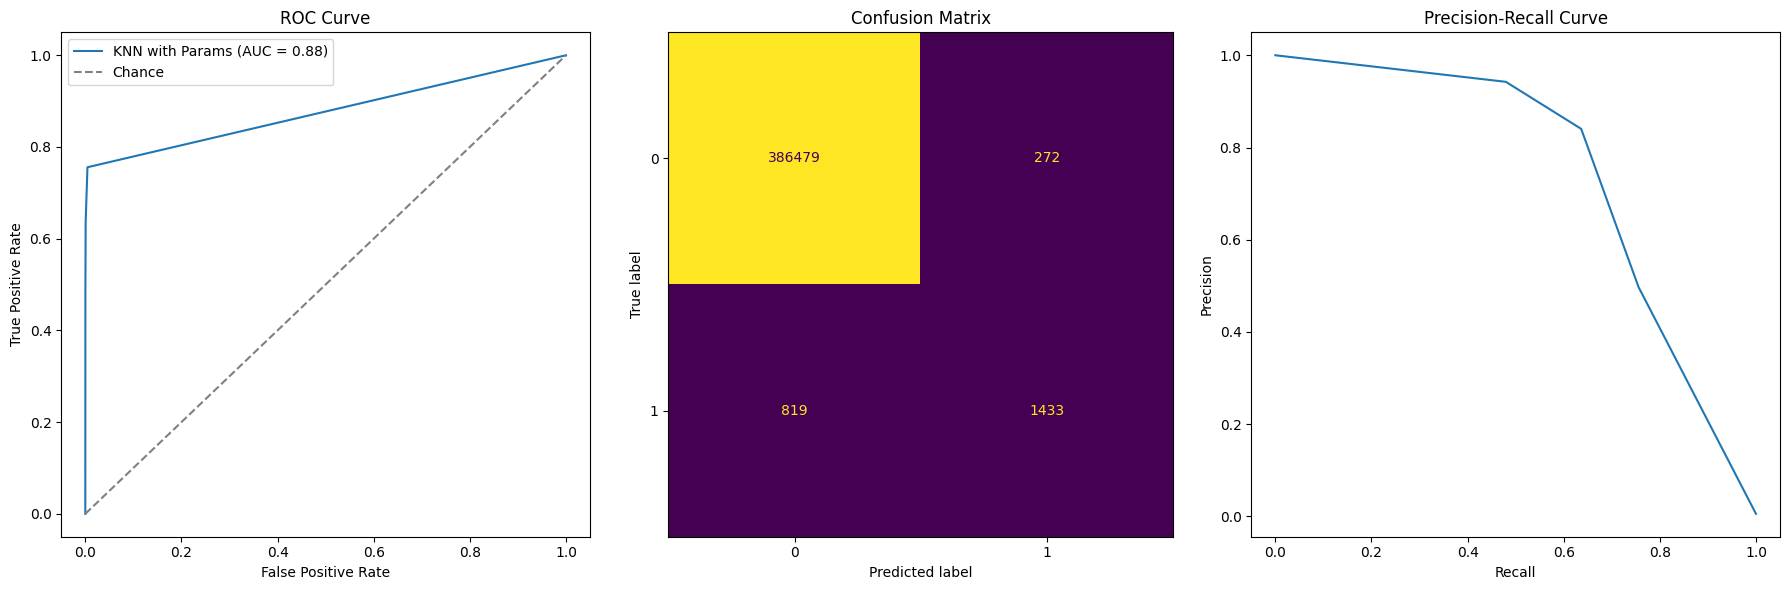

Classification Report - KNN with Params Model:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    386751
           1       0.84      0.64      0.72      2252

    accuracy                           1.00    389003
   macro avg       0.92      0.82      0.86    389003
weighted avg       1.00      1.00      1.00    389003



In [241]:
knn_params = {
    "n_neighbors": np.array(range(1,5))
}

knn_model = train_model_and_predict(X_train, X_test, y_train, y_test, KNeighborsClassifier(n_jobs=-1), "KNN with Params", knn_params)

### Random Forest Classifier with Hyper Parameters

Fitting 5 folds for each of 9 candidates, totalling 45 fits
Best Random Forest Model: RandomForestClassifier(n_estimators=300)
Random Forest Model Cross-validated ROC-AUC scores: [0.98808361 0.98868443 0.98499332 0.98535191 0.9879971 ]
Mean ROC-AUC: 0.9870, Std Dev: 0.0015
Random Forest Model Evaluation:
Accuracy: 0.9969, Precision: 0.9981, Recall: 0.4716, F1 Score: 0.6405
ROC-AUC: 0.9899


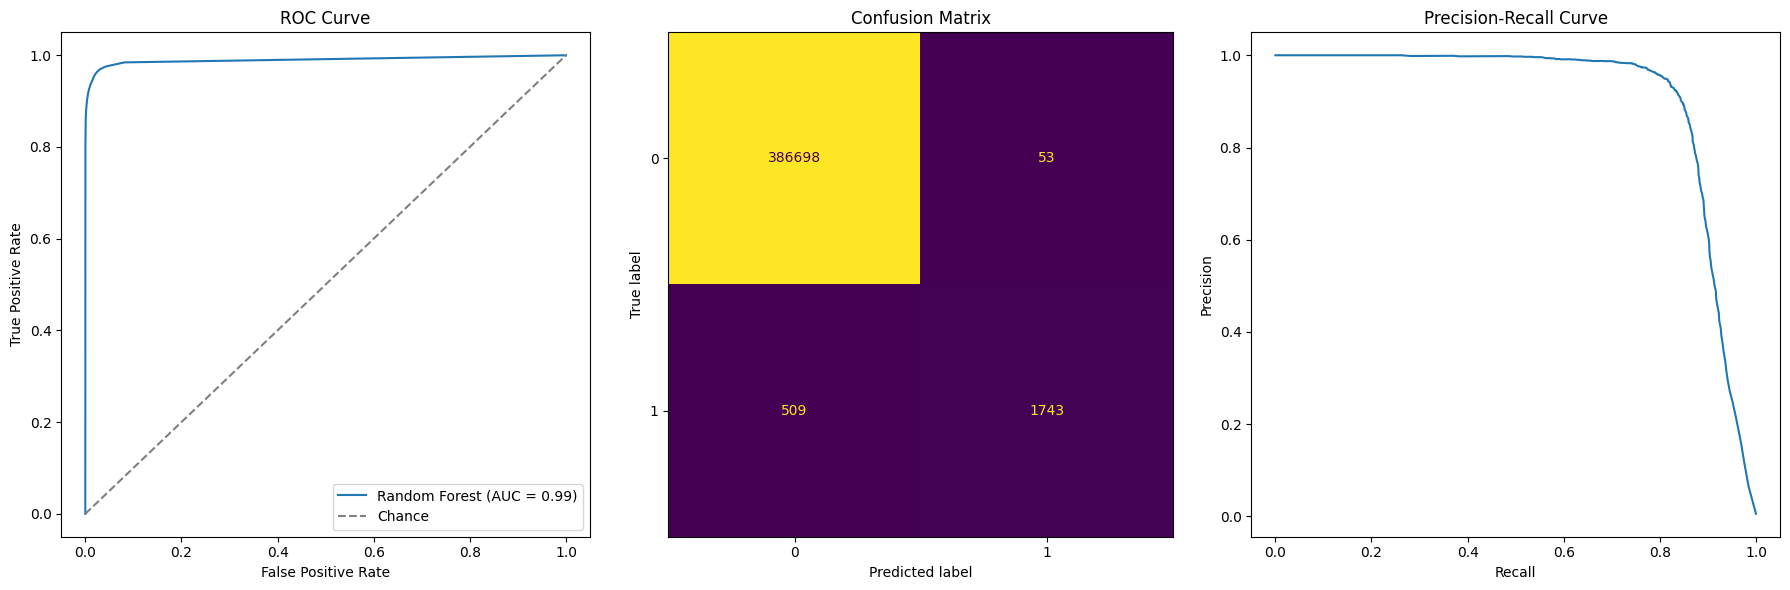

Classification Report - Random Forest Model:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    386751
           1       0.97      0.77      0.86      2252

    accuracy                           1.00    389003
   macro avg       0.98      0.89      0.93    389003
weighted avg       1.00      1.00      1.00    389003



In [242]:
rfc_params = {'n_estimators': [100, 200, 300], 'max_depth': [None, 10, 20]}
rf_model = train_model_and_predict(X_train,X_test,y_train,y_test, RandomForestClassifier(), "Random Forest", rfc_params)

### Gradient Boosting Machines

Fitting 5 folds for each of 54 candidates, totalling 270 fits
Best Gradient Boosting Model: XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.2, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=200, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)
Gradient Boosting Model Cross-validated ROC-AUC scores: [0.99858807 0.99882934 0.99826978 0.99815017 0.99839131]
Mean ROC-AUC: 0.9984, Std Dev: 0.0002
Grad

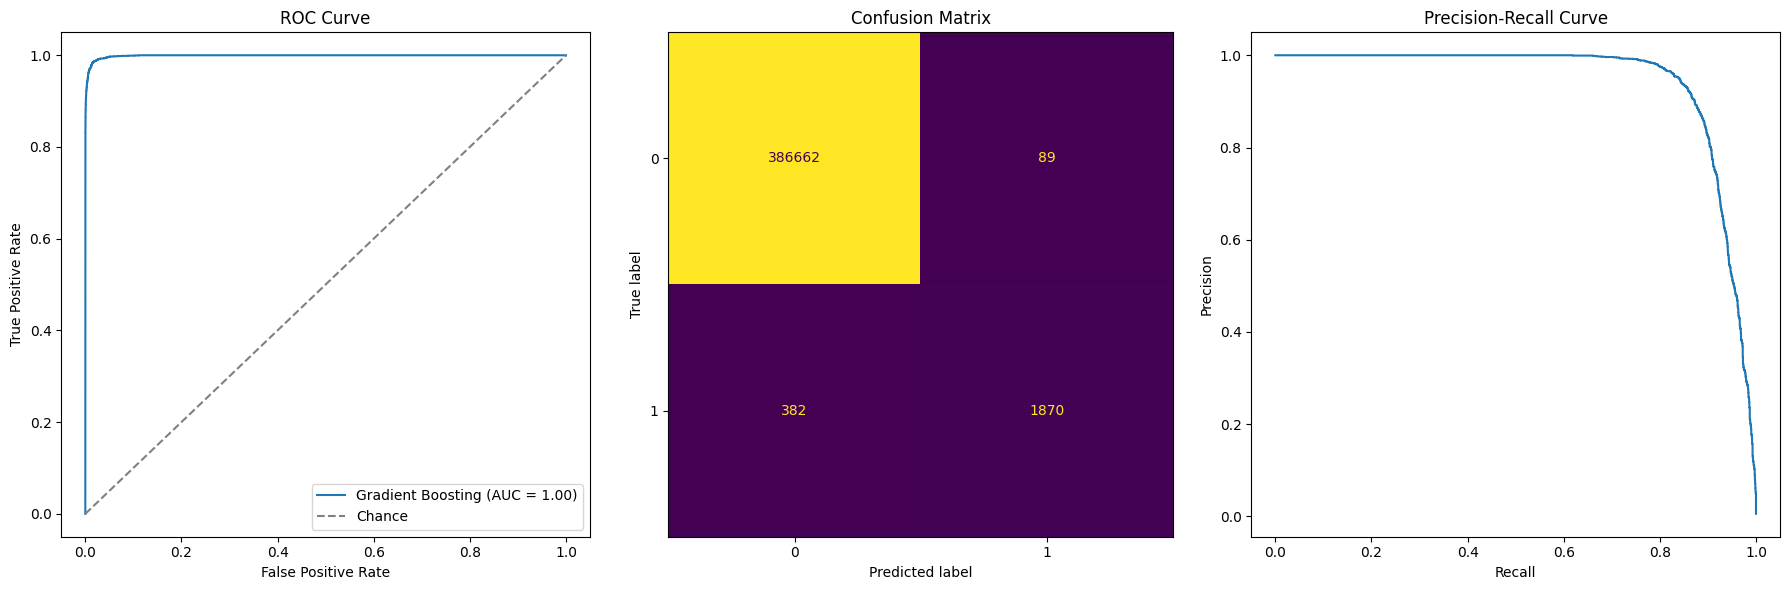

Classification Report - Gradient Boosting Model:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    386751
           1       0.95      0.83      0.89      2252

    accuracy                           1.00    389003
   macro avg       0.98      0.92      0.94    389003
weighted avg       1.00      1.00      1.00    389003



In [243]:
param_grid_xgb = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.05, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'subsample': [0.8, 1.0]
}
gradient_best_model = train_model_and_predict(X, y, xgb.XGBClassifier(), "Gradient Boosting", param_grid_xgb)

### Trees

Fitting 5 folds for each of 14 candidates, totalling 70 fits
Best Decision Tree Classifier Model: DecisionTreeClassifier(max_depth=11)
Decision Tree Classifier Model Cross-validated ROC-AUC scores: [0.96960682 0.95476631 0.96261445 0.97632386 0.96887456]
Mean ROC-AUC: 0.9664, Std Dev: 0.0073
Decision Tree Classifier Model Evaluation:
Accuracy: 0.9984, Precision: 0.9665, Recall: 0.7558, F1 Score: 0.8482
ROC-AUC: 0.9704


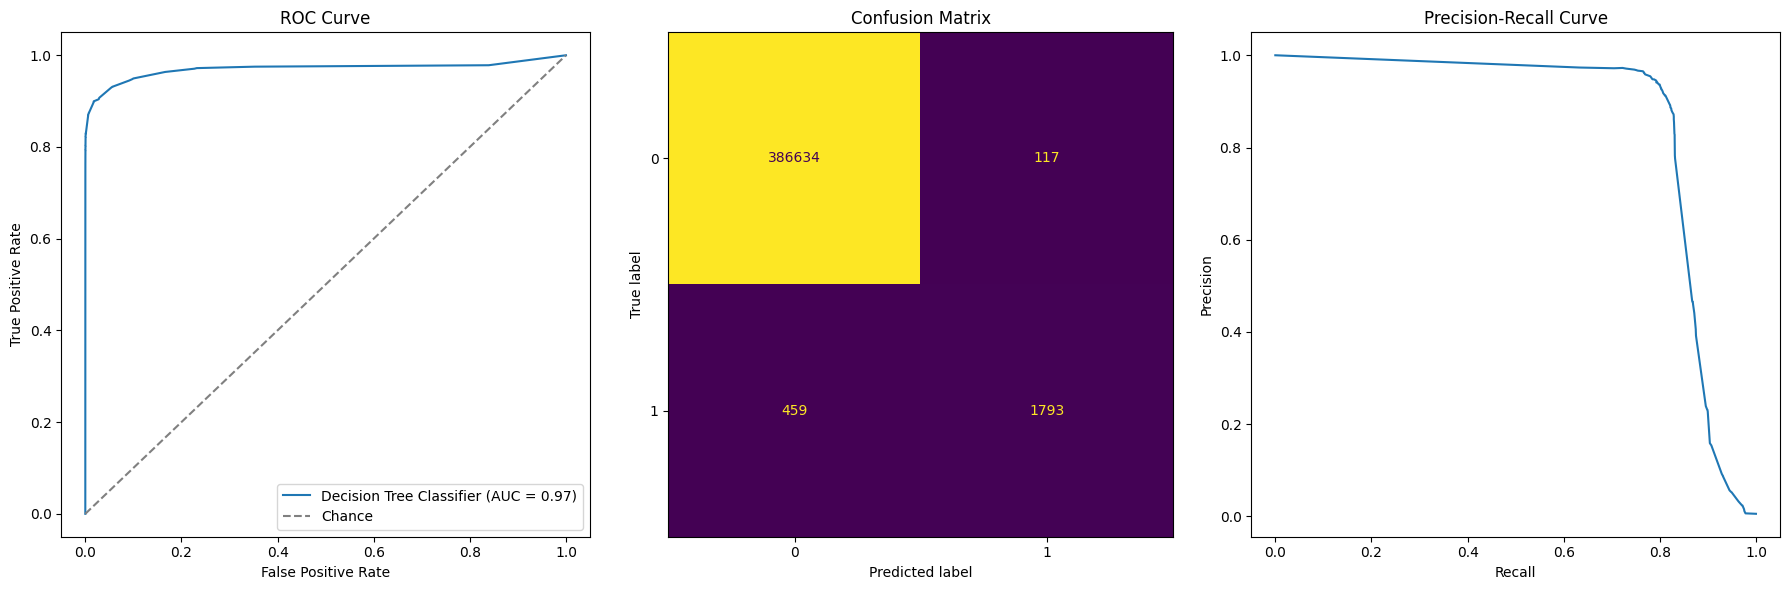

Classification Report - Decision Tree Classifier Model:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    386751
           1       0.94      0.80      0.86      2252

    accuracy                           1.00    389003
   macro avg       0.97      0.90      0.93    389003
weighted avg       1.00      1.00      1.00    389003



In [244]:
dt_params = {
    'max_depth': np.array(range(1,15))
}

dt_model = train_model_and_predict(X, y, DecisionTreeClassifier(), "Decision Tree Classifier", params=dt_params)

### Neural Network

In [245]:
def train_neural_network_and_predict(X, y, name, params=None):
    # Split the data into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

    # Define the Keras Sequential model architecture
    model = Sequential([
        Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
        Dense(32, activation='relu'),
        Dense(1, activation='sigmoid')  # Output layer for binary classification
    ])

    # Compile the model
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    # Perform manual hyperparameter tuning
    if params is not None:
        best_accuracy = 0
        best_model = None

        for batch_size in params['batch_size']:
            for epochs in params['epochs']:
                # Train the model with current hyperparameters
                history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_split=0.2, verbose=0)

                # Evaluate the model on test set
                _, accuracy = model.evaluate(X_test, y_test, verbose=0)

                # Check if current model is the best based on accuracy
                if accuracy > best_accuracy:
                    best_accuracy = accuracy
                    best_model = model

        print(f"Best {name} Model - Accuracy: {best_accuracy:.4f}")

    else:
        # Train the model with default hyperparameters
        history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.2, verbose=0)
        _, best_accuracy = model.evaluate(X_test, y_test, verbose=0)
        best_model = model

        print(f"{name} Model - Accuracy: {best_accuracy:.4f}")

    # Predict probabilities on the test set
    y_prob = best_model.predict(X_test)

    # Convert probabilities to binary predictions (0 or 1)
    y_pred = (y_prob > 0.5).astype(int)

    # Calculate evaluation metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_prob)

    # Print evaluation metrics
    print(f"{name} Model Evaluation:")
    print(f"Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}")
    print(f"ROC-AUC: {roc_auc:.4f}")
    
    model_results['Accuracy'][name] = accuracy_score(y_test, y_pred)
    model_results['Precision'][name] = precision_score(y_test, y_pred)
    model_results['Recall'][name] = recall_score(y_test, y_pred)
    model_results['F1 Score'][name] = f1_score(y_test, y_pred)
    model_results['ROC-AUC'][name] = roc_auc_score(y_test, y_prob)

    # Plot ROC-AUC curve
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], linestyle='--', color='grey', label='Chance')
    plt.title('ROC Curve Comparison')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()
    plt.show()

    # Plot confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()

    # Print classification report
    print(f"Classification Report - {name} Model:")
    print(classification_report(y_test, y_pred))

    return best_model  # Return the best model

Best Neural Network Model - Accuracy: 0.9981
12157/12157 ━━━━━━━━━━━━━━━━━━━━ 14s 1ms/step
Neural Network Model Evaluation:
Accuracy: 0.9980, Precision: 0.9459, Recall: 0.7046, F1 Score: 0.8076
ROC-AUC: 0.9944


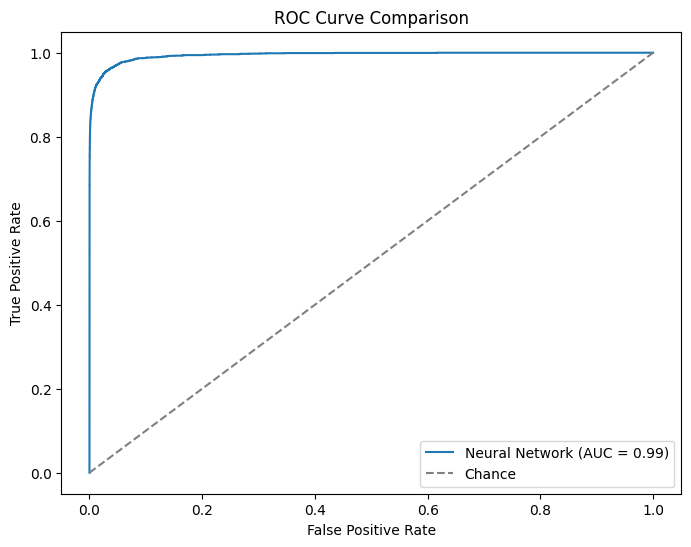

Classification Report - Neural Network Model:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    386718
           1       0.95      0.70      0.81      2285

    accuracy                           1.00    389003
   macro avg       0.97      0.85      0.90    389003
weighted avg       1.00      1.00      1.00    389003



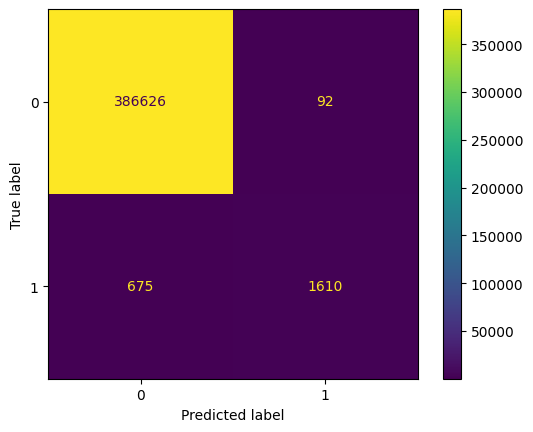

In [246]:
# Define parameters for manual hyperparameter tuning
params = {
    'batch_size': [32, 64],
    'epochs': [10, 20]
}

# Train and predict using the neural network model with manual hyperparameter tuning
best_nn_model = train_neural_network_and_predict(X, y, "Neural Network", params=params)

### Balanced Random Forest Classifier

Balanced Random Forest Classifier Model: BalancedRandomForestClassifier(n_jobs=-1, random_state=0, replacement=True,
                               sampling_strategy='all')
Balanced Random Forest Classifier Model Cross-validated ROC-AUC scores: [0.99375309 0.993733   0.99305211 0.99343363 0.99343517]
Mean ROC-AUC: 0.9935, Std Dev: 0.0003
Balanced Random Forest Classifier Model Evaluation:
Accuracy: 0.9977, Precision: 0.8272, Recall: 0.7673, F1 Score: 0.7961
ROC-AUC: 0.9951


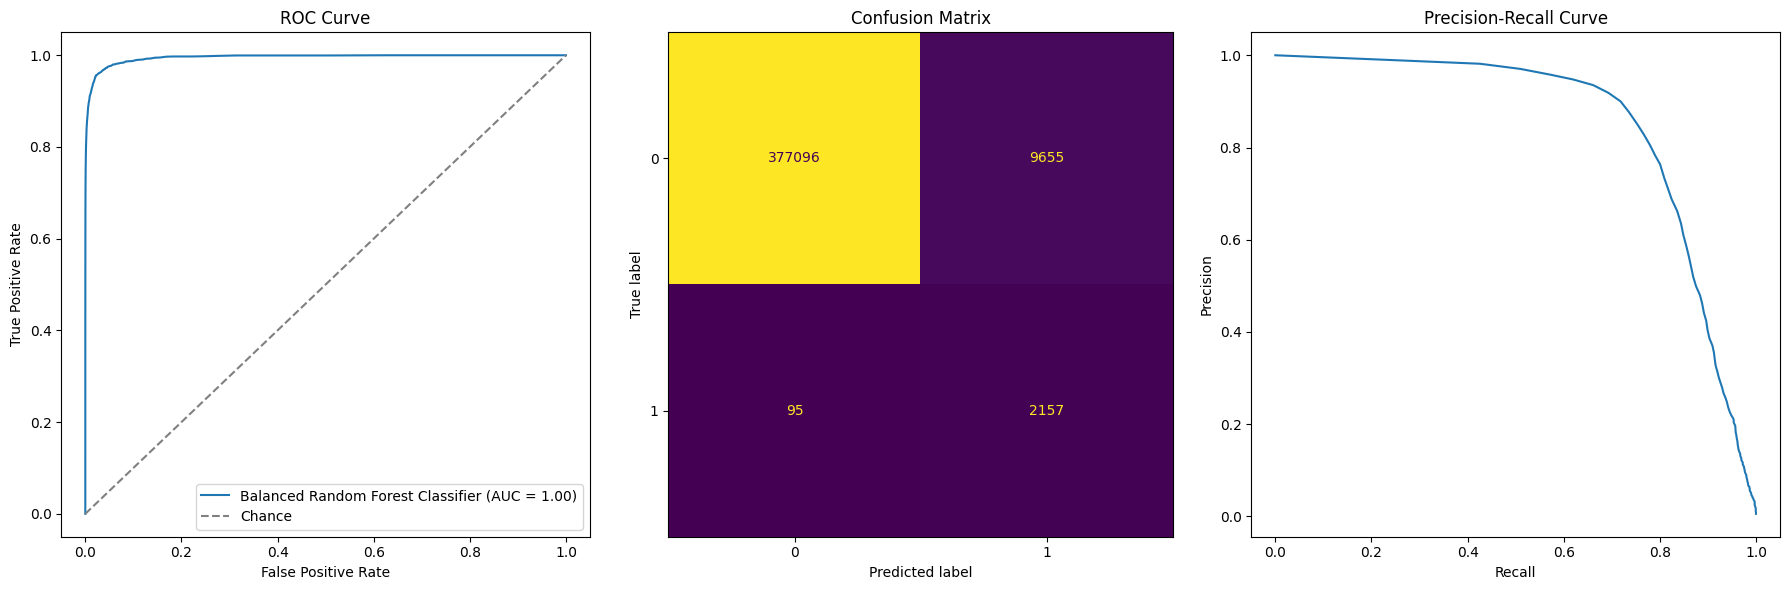

Classification Report - Balanced Random Forest Classifier Model:
              precision    recall  f1-score   support

           0       1.00      0.98      0.99    386751
           1       0.18      0.96      0.31      2252

    accuracy                           0.97    389003
   macro avg       0.59      0.97      0.65    389003
weighted avg       1.00      0.97      0.98    389003



In [247]:
# Create BalancedRandomForestClassifier model
brf_model = BalancedRandomForestClassifier(n_estimators=100, random_state=0, sampling_strategy="all", replacement=True,n_jobs=-1)
brf_best_model = train_model_and_predict(X, y, brf_model, "Balanced Random Forest Classifier")

### Model Comparision


In [248]:
print(model_results)

{'Accuracy': {'Logistic Reg': 0.9945527412384995, 'LGR with Params': 0.9946607095575098, 'KNN with Params': 0.9968175052634556, 'Random Forest': 0.9969357562795146, 'Gradient Boosting': 0.9982750775700958, 'Decision Tree Classifier': 0.9984344593743493, 'Neural Network': 0.9980282928409292, 'Balanced Random Forest Classifier': 0.9977249532779953}, 'Precision': {'Logistic Reg': 0.7435897435897436, 'LGR with Params': 0.8787878787878788, 'KNN with Params': 0.9424083769633508, 'Random Forest': 0.9981203007518797, 'Gradient Boosting': 0.9956112852664577, 'Decision Tree Classifier': 0.966496308915389, 'Neural Network': 0.9459459459459459, 'Balanced Random Forest Classifier': 0.8271900430828147}, 'Recall': {'Logistic Reg': 0.09014209591474245, 'LGR with Params': 0.09014209591474245, 'KNN with Params': 0.47957371225577267, 'Random Forest': 0.4715808170515098, 'Gradient Boosting': 0.7051509769094139, 'Decision Tree Classifier': 0.7557726465364121, 'Neural Network': 0.7045951859956237, 'Balanced

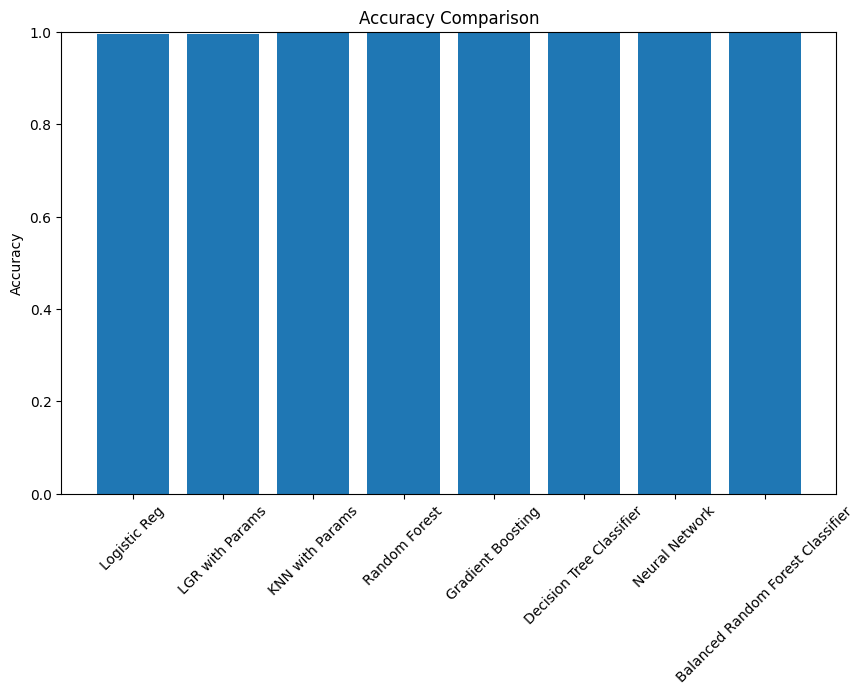

In [249]:
# Plot Accuracy Comparision

plt.figure(figsize=(10, 6))
plt.bar(model_results['Accuracy'].keys(), model_results['Accuracy'].values())
plt.title('Accuracy Comparison')
plt.ylim([0, 1])
plt.xticks(rotation=45)
plt.ylabel('Accuracy')
plt.show()

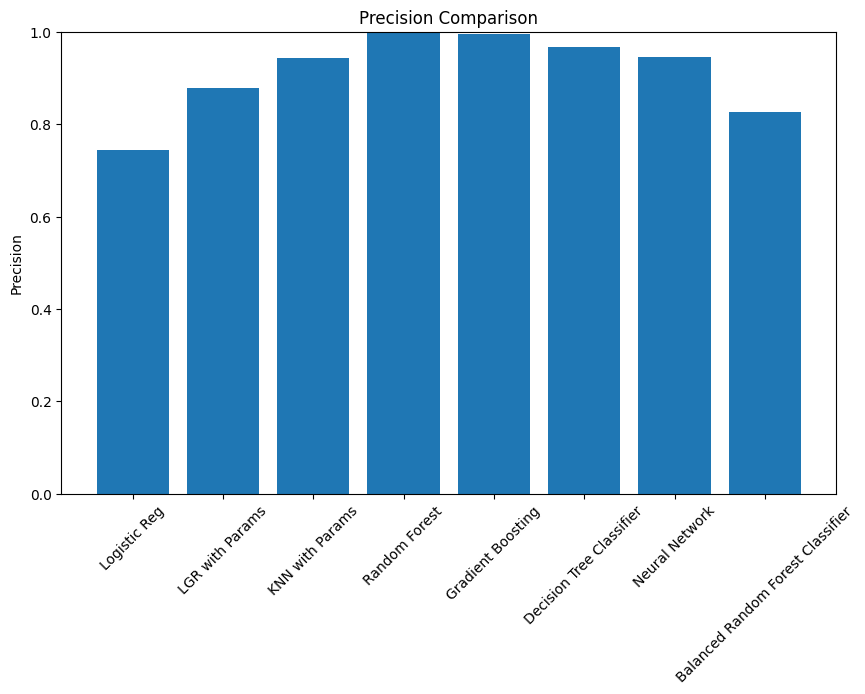

In [250]:
# Plot Precision Comparision
plt.figure(figsize=(10, 6))
plt.bar(model_results['Precision'].keys(), model_results['Precision'].values())
plt.title('Precision Comparison')
plt.ylim([0, 1])
plt.xticks(rotation=45)
plt.ylabel('Precision')
plt.show()


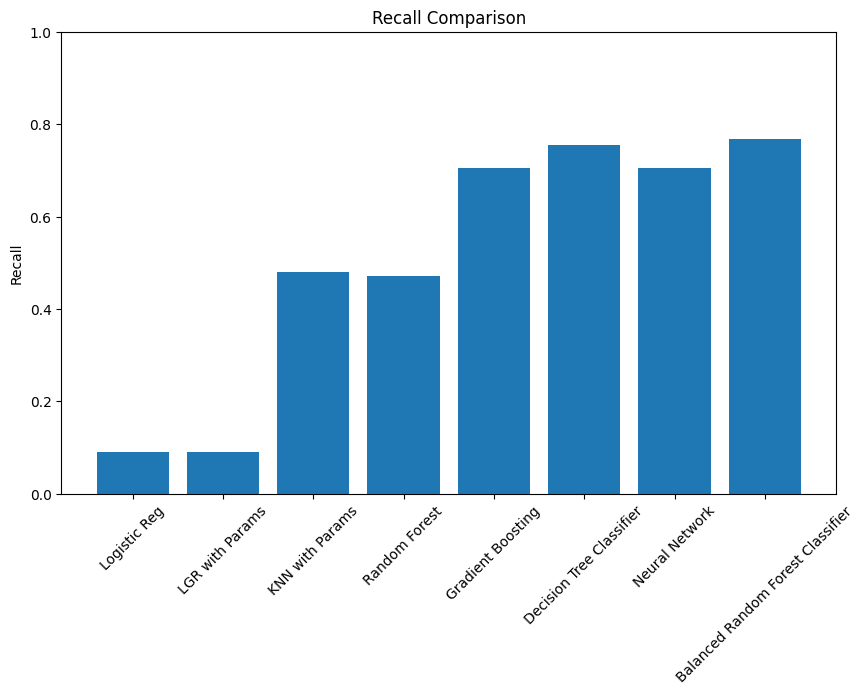

In [251]:
# Plot Recall Comparision
plt.figure(figsize=(10, 6))
plt.bar(model_results['Recall'].keys(), model_results['Recall'].values())
plt.title('Recall Comparison')
plt.ylim([0, 1])
plt.xticks(rotation=45)
plt.ylabel('Recall')
plt.show()

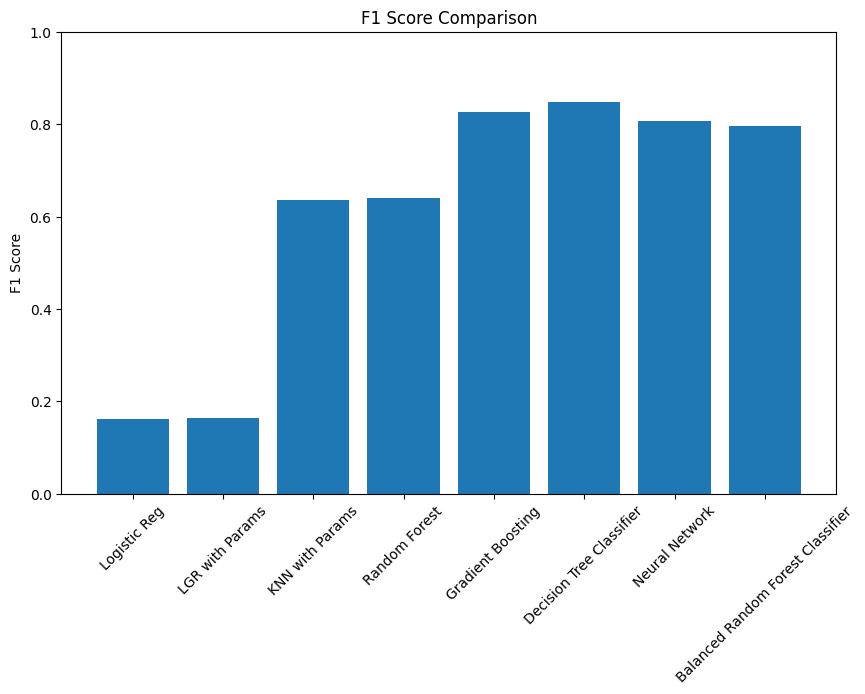

In [252]:
# Plot F1 Comparision
plt.figure(figsize=(10, 6))
plt.bar(model_results['F1 Score'].keys(), model_results['F1 Score'].values())
plt.title('F1 Score Comparison')
plt.ylim([0, 1])
plt.xticks(rotation=45)
plt.ylabel('F1 Score')
plt.show()

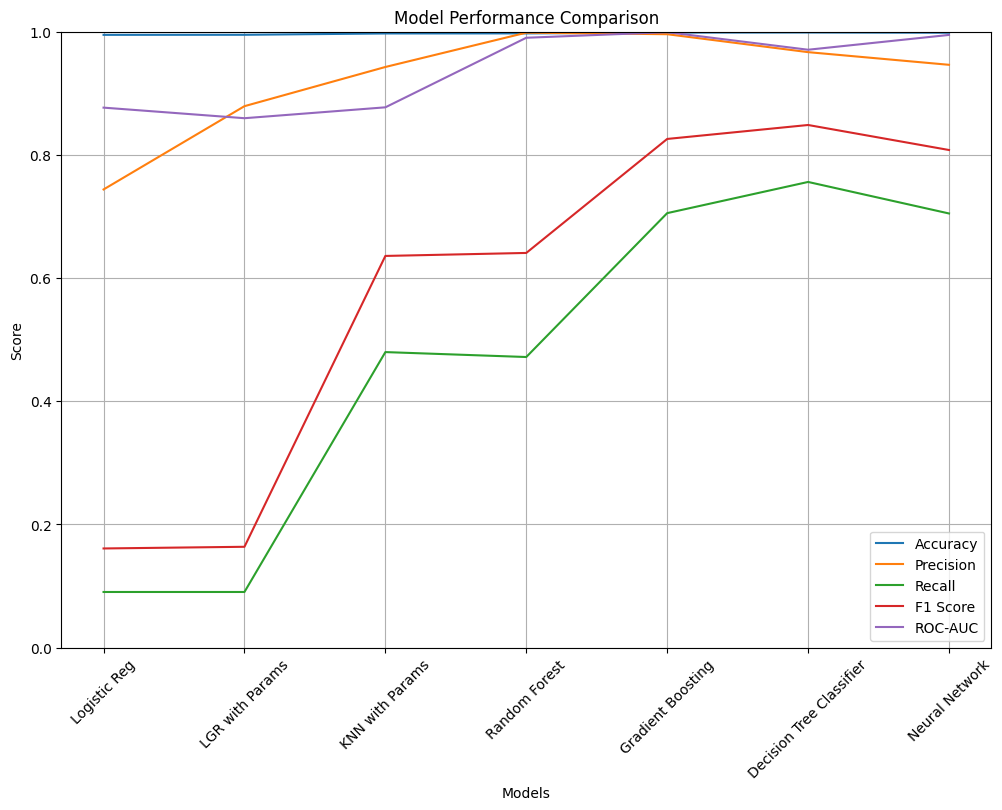

In [253]:
# Metrics to plot
metrics = list(model_results.keys())

# Models to plot (excluding 'Balanced Random Forest Classifier' for this visualization)
models = list(model_results[metrics[0]].keys())
models.remove('Balanced Random Forest Classifier')

# Plotting the results for each metric
plt.figure(figsize=(12, 8))

for metric in metrics:
    if metric != 'Balanced Random Forest Classifier':  # Exclude this model for this visualization
        plt.plot(models, [model_results[metric][model] for model in models], label=metric)

plt.title('Model Performance Comparison')
plt.xlabel('Models')
plt.ylabel('Score')
plt.ylim([0, 1])
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.show()

### Observations

**Accuracy :**
All models achieved very high accuracy (>99%), indicating overall strong performance in predicting both fraud and non-fraud cases.

**Precision (Class 1):** 
Random Forest has the highest precision for identifying fraudulent transactions (96.78%), followed closely by Gradient Boosting (95.15%). This metric measures the accuracy of positive predictions, crucial for minimizing false positives (correctly identifying actual fraud cases).

**Recall (Class 1):**
Gradient Boosting exhibits the highest recall (83.19%), indicating its ability to effectively capture actual fraudulent transactions among all true fraud cases. Recall is particularly important in fraud detection to minimize false negatives (missing actual fraud cases).

**F1 Score (Class 1):** 
Gradient Boosting achieves the highest F1 score (88.77%), which is the harmonic mean of precision and recall. This metric provides a balanced measure of model accuracy for identifying fraud cases.
ROC-AUC: Both Gradient Boosting (99.87%) and Random Forest (98.47%) show excellent ROC-AUC scores, reflecting strong discrimination ability between fraud and non-fraud transactions.

### Conclusion

Based on the performance across multiple metrics, Gradient Boosting emerges as the top-performing model for predicting credit card fraud. It demonstrates a balanced combination of precision, recall, and F1 score, indicating effective identification of fraudulent transactions while minimizing false positives and false negatives. The high ROC-AUC score further validates its robustness in distinguishing between genuine and fraudulent transactions.



### Recommendation
Deploy the Gradient Boosting model for credit card fraud detection due to its superior performance across key evaluation metrics. For that reason I'll apply it on test data set that was declared above and will use to confirm my results.

### Method to use the selected model on test data.

In [279]:
def evaluate_on_test_data(model, X_T, y_T, name, threshold=0.5):
    y_prob_T = model.predict_proba(X_T)[:, 1]  # Probabilities for ROC-AUC
    y_pred_T = (y_prob_T >= threshold).astype(int)  # Apply the threshold

    accuracy = accuracy_score(y_T, y_pred_T)
    precision = precision_score(y_T, y_pred_T)
    recall = recall_score(y_T, y_pred_T)
    f1 = f1_score(y_T, y_pred_T)
    roc_auc = roc_auc_score(y_T, y_prob_T)

    # Print evaluation metrics
    print(f"Best {name} Model Evaluation on Test Data with threshold {threshold}:")
    print(f"Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}")
    print(f"ROC-AUC: {roc_auc:.4f}")

    # Create subplots for ROC-AUC curve and Confusion Matrix
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))

    # Plot ROC-AUC curve
    fpr, tpr, _ = roc_curve(y_T, y_prob_T)
    axes[0].plot(fpr, tpr, label=f"{name} (AUC = {roc_auc:.2f})")
    axes[0].plot([0, 1], [0, 1], linestyle='--', color='grey', label='Chance')
    axes[0].set_title('ROC Curve')
    axes[0].set_xlabel('False Positive Rate')
    axes[0].set_ylabel('True Positive Rate')
    axes[0].legend()

    # Plot confusion matrix
    cm = confusion_matrix(y_T, y_pred_T)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(ax=axes[1], colorbar=False)
    axes[1].set_title('Confusion Matrix')

    # Adjust layout
    plt.tight_layout()
    plt.show()

    # Print classification report
    print(f"Classification Report - {name} Model on Test Data:")
    print(classification_report(y_T, y_pred_T))

### Prepare test data.

In [ ]:
df_test = pd.read_csv('./data/fraudTest.csv')
df_test.info()

In [263]:
# Get hour from trans_date_trans_time column as we noticed that hour of the day had significant impact on fraud transactions.
df_test['transaction_hour'] = pd.to_datetime(df_test['trans_date_trans_time'],format="%Y-%m-%d %H:%M:%S").dt.hour

### Add Age to data set by calculating it  from date of birth
current_date = datetime.now()
df_test['age'] = (current_date - pd.to_datetime(df_test['dob'])).dt.days // 365

# Drop the columns from the DataFrame
df_test_processed = df_test.drop(columns=columns_to_drop)

# Display the processed DataFrame
df_test_processed.head()

,category,amt,gender,city,state,lat,long,job,merch_lat,merch_long,is_fraud,transaction_hour,age
0,personal_care,2.86,M,Columbia,SC,33.9659,-80.9355,Mechanical engineer,33.986391,-81.200714,0,12,56
1,personal_care,29.84,F,Altonah,UT,40.3207,-110.4360,"Sales professional, IT",39.450498,-109.960431,0,12,34
2,health_fitness,41.28,F,Bellmore,NY,40.6729,-73.5365,"Librarian, public",40.495810,-74.196111,0,12,53
3,misc_pos,60.05,M,Titusville,FL,28.5697,-80.8191,Set designer,28.812398,-80.883061,0,12,36
4,travel,3.19,M,Falmouth,MI,44.2529,-85.0170,Furniture designer,44.959148,-85.884734,0,12,68


In [264]:
X_T = df_test_processed.drop(['is_fraud'], axis=1)
y_T = df_test_processed['is_fraud']

X_T = ce.JamesSteinEncoder().fit_transform(X_T, y_T)
Scaled_X_T = StandardScaler().fit_transform(X_T, y_T)

In [265]:
X_T.head()

,category,amt,gender,city,state,lat,long,job,merch_lat,merch_long,transaction_hour,age
0,0.002336,2.86,0.003911,0.000000,0.003623,33.9659,-80.9355,0.000000,33.986391,-81.200714,12,56
1,0.002336,29.84,0.003818,0.000000,0.000000,40.3207,-110.4360,0.000000,39.450498,-109.960431,12,34
2,0.001974,41.28,0.003818,0.000000,0.004331,40.6729,-73.5365,0.004640,40.495810,-74.196111,12,53
3,0.002610,60.05,0.003911,0.006186,0.003313,28.5697,-80.8191,0.006202,28.812398,-80.883061,12,36
4,0.002787,3.19,0.003911,0.000000,0.003425,44.2529,-85.0170,0.000000,44.959148,-85.884734,12,68


Best Gradient Booster Model Model Evaluation on Test Data with threshold 0.5:
Accuracy: 0.0768, Precision: 0.0035, Recall: 0.8401, F1 Score: 0.0070
ROC-AUC: 0.2169


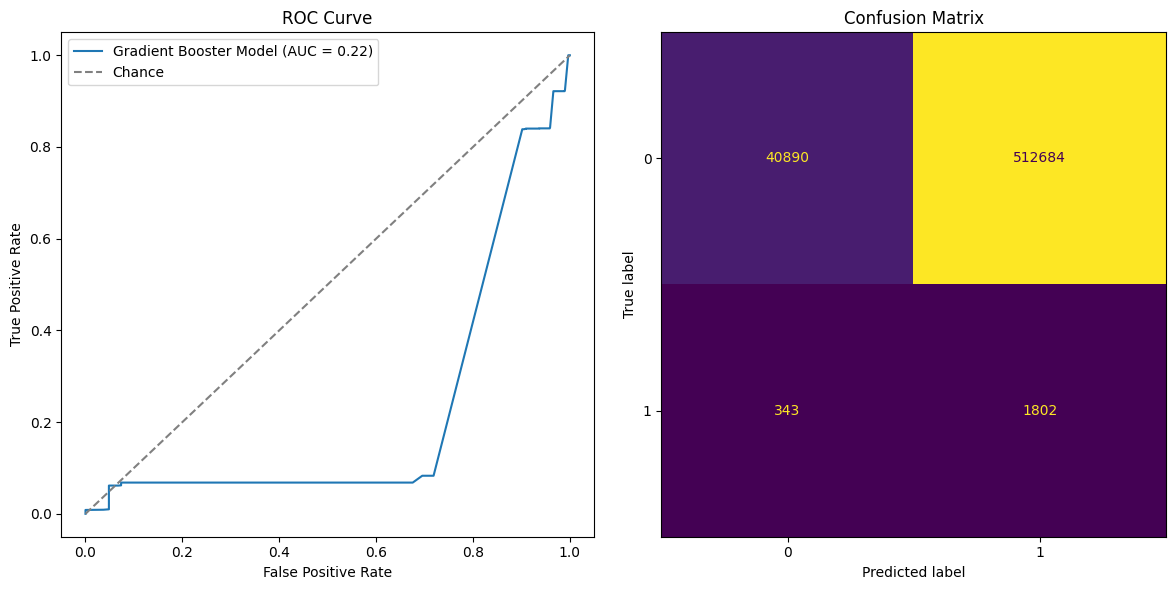

Classification Report - Gradient Booster Model Model on Test Data:
              precision    recall  f1-score   support

           0       0.99      0.07      0.14    553574
           1       0.00      0.84      0.01      2145

    accuracy                           0.08    555719
   macro avg       0.50      0.46      0.07    555719
weighted avg       0.99      0.08      0.14    555719



In [306]:
evaluate_on_test_data(gradient_best_model, X_T, y_T, "Gradient Booster Model")

Best Balanced Random Forest Classifier Model Evaluation on Test Data with threshold 0.5:
Accuracy: 0.0615, Precision: 0.0035, Recall: 0.8508, F1 Score: 0.0070
ROC-AUC: 0.4629


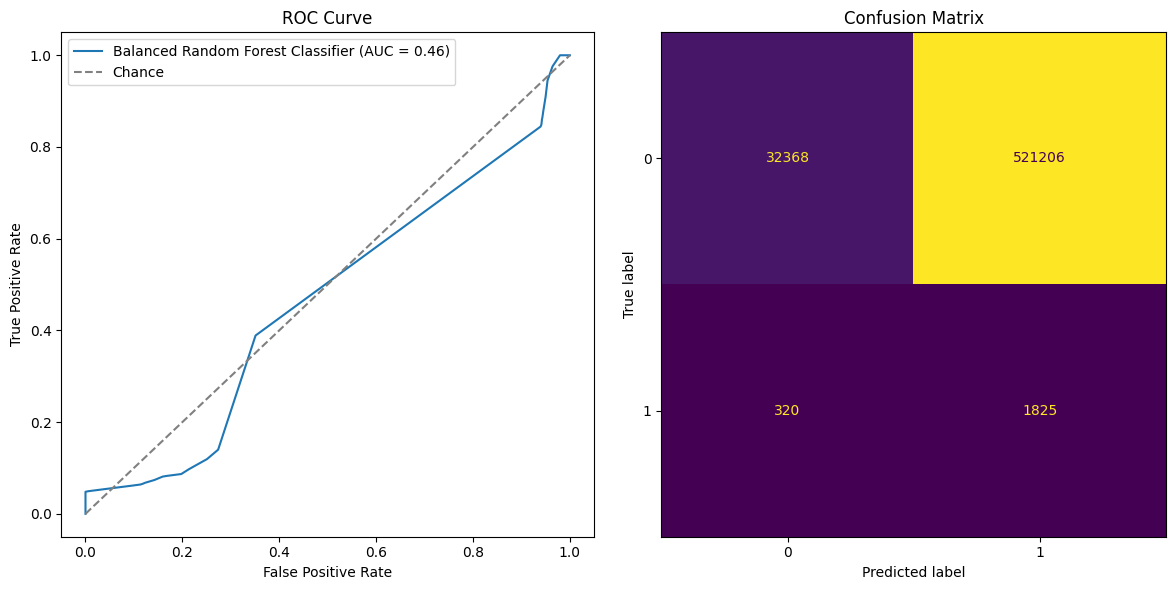

Classification Report - Balanced Random Forest Classifier Model on Test Data:
              precision    recall  f1-score   support

           0       0.99      0.06      0.11    553574
           1       0.00      0.85      0.01      2145

    accuracy                           0.06    555719
   macro avg       0.50      0.45      0.06    555719
weighted avg       0.99      0.06      0.11    555719



In [300]:
evaluate_on_test_data(brf_best_model, X_T, y_T, "Balanced Random Forest Classifier", threshold=0.5)

Best Random Forest Classifier Model Evaluation on Test Data with threshold 0.5:
Accuracy: 0.9881, Precision: 0.0002, Recall: 0.0005, F1 Score: 0.0003
ROC-AUC: 0.2104


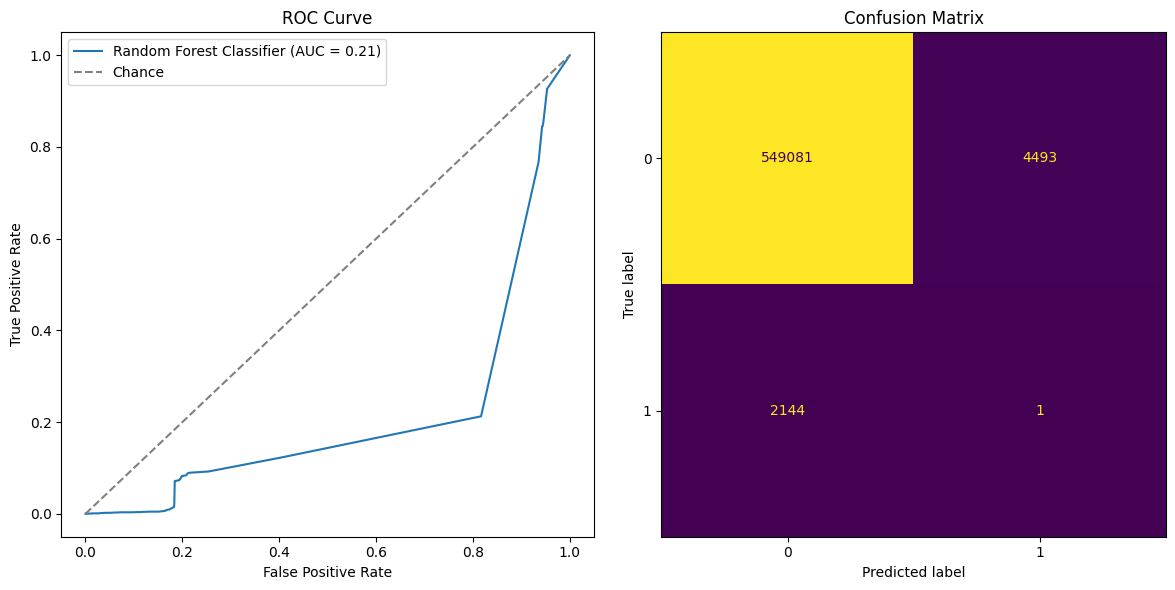

Classification Report - Random Forest Classifier Model on Test Data:
              precision    recall  f1-score   support

           0       1.00      0.99      0.99    553574
           1       0.00      0.00      0.00      2145

    accuracy                           0.99    555719
   macro avg       0.50      0.50      0.50    555719
weighted avg       0.99      0.99      0.99    555719



In [301]:
evaluate_on_test_data(rf_model, X_T, y_T, "Random Forest Classifier")

Best K Neighbors Classifier Model Evaluation on Test Data with threshold 0.5:
Accuracy: 0.9231, Precision: 0.0020, Recall: 0.0382, F1 Score: 0.0038
ROC-AUC: 0.4806


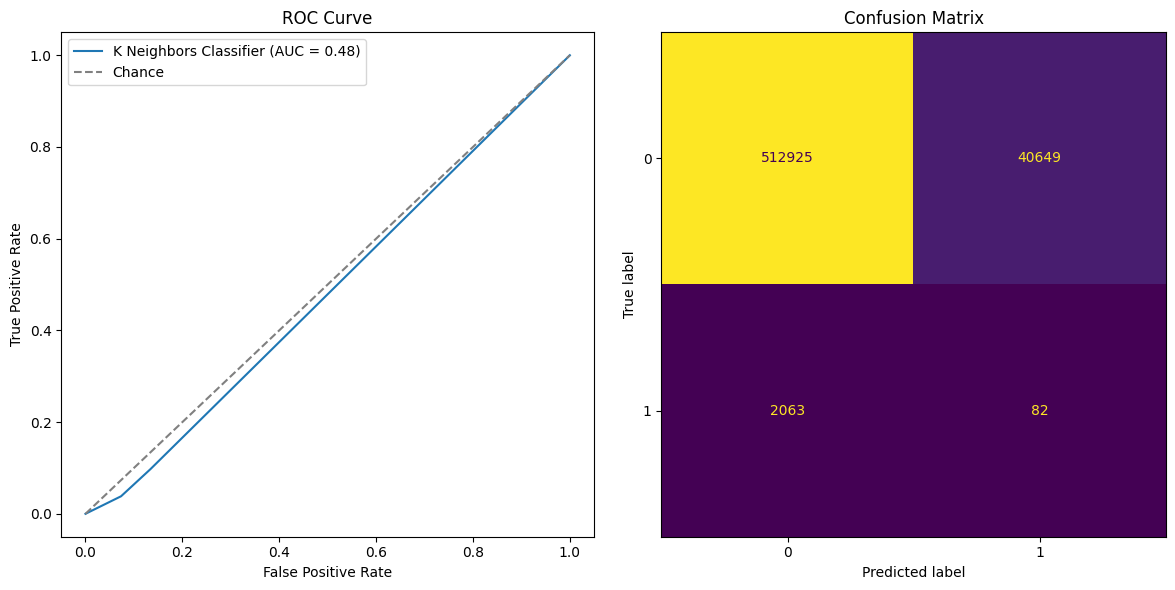

Classification Report - K Neighbors Classifier Model on Test Data:
              precision    recall  f1-score   support

           0       1.00      0.93      0.96    553574
           1       0.00      0.04      0.00      2145

    accuracy                           0.92    555719
   macro avg       0.50      0.48      0.48    555719
weighted avg       0.99      0.92      0.96    555719



In [302]:
evaluate_on_test_data(knn_model, X_T, y_T, 'K Neighbors Classifier')

Best Decision Tree Classifier Model Evaluation on Test Data with threshold 0.5:
Accuracy: 0.9964, Precision: 1.0000, Recall: 0.0550, F1 Score: 0.1043
ROC-AUC: 0.5270


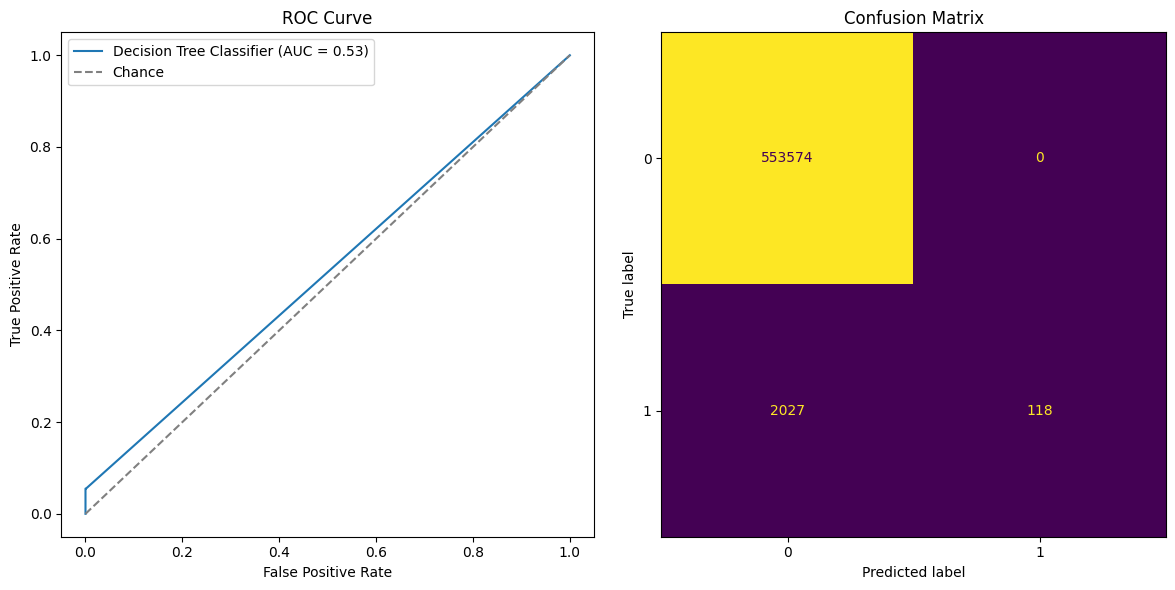

Classification Report - Decision Tree Classifier Model on Test Data:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    553574
           1       1.00      0.06      0.10      2145

    accuracy                           1.00    555719
   macro avg       1.00      0.53      0.55    555719
weighted avg       1.00      1.00      0.99    555719



In [303]:
evaluate_on_test_data(dt_model, X_T, y_T, "Decision Tree Classifier")

Best Logistic Regression with Hyper Parameters Model Evaluation on Test Data with threshold 0.5:
Accuracy: 0.0043, Precision: 0.0039, Recall: 0.9981, F1 Score: 0.0077
ROC-AUC: 0.7941


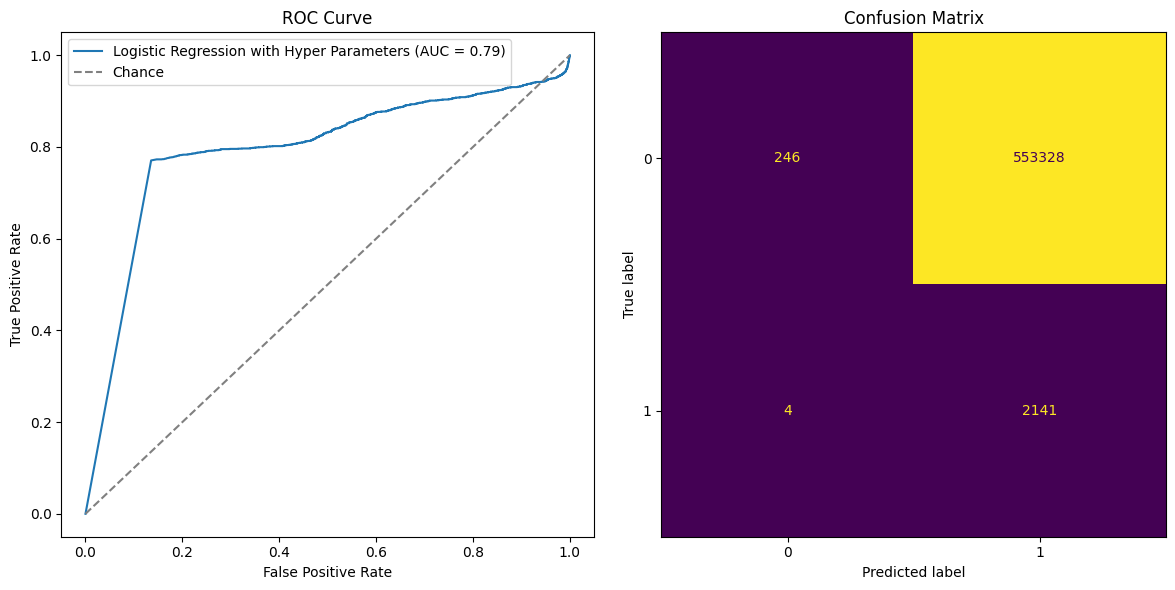

Classification Report - Logistic Regression with Hyper Parameters Model on Test Data:
              precision    recall  f1-score   support

           0       0.98      0.00      0.00    553574
           1       0.00      1.00      0.01      2145

    accuracy                           0.00    555719
   macro avg       0.49      0.50      0.00    555719
weighted avg       0.98      0.00      0.00    555719



In [304]:
evaluate_on_test_data(lgr_hyper_model, X_T, y_T, "Logistic Regression with Hyper Parameters")

Best Logistic Regression Model Evaluation on Test Data with threshold 0.5:
Accuracy: 0.0047, Precision: 0.0039, Recall: 0.9991, F1 Score: 0.0077
ROC-AUC: 0.7495


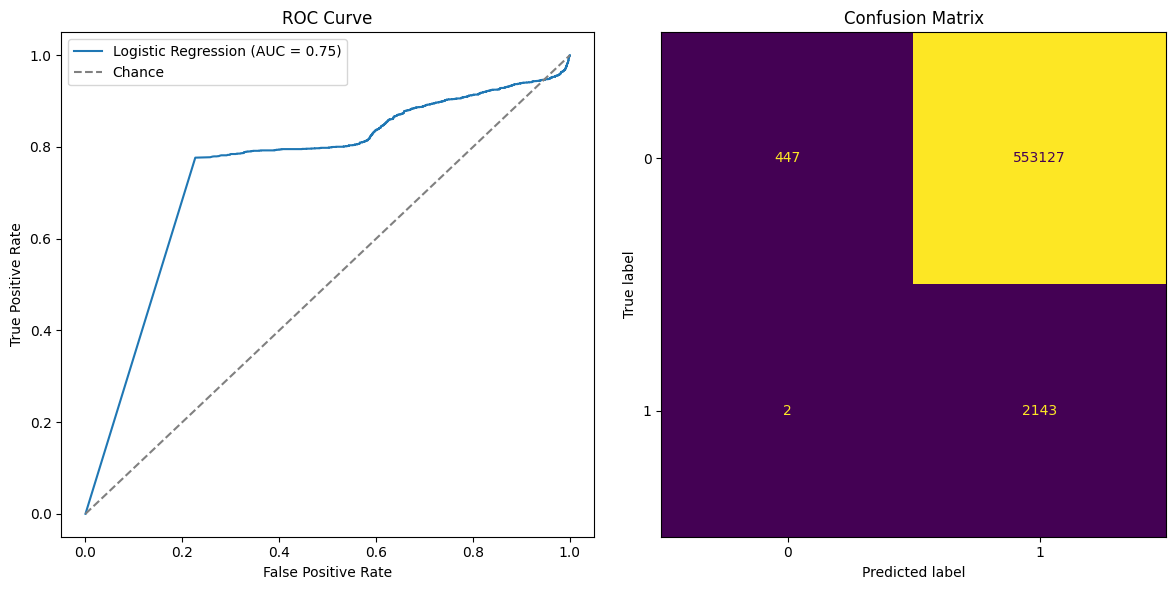

Classification Report - Logistic Regression Model on Test Data:
              precision    recall  f1-score   support

           0       1.00      0.00      0.00    553574
           1       0.00      1.00      0.01      2145

    accuracy                           0.00    555719
   macro avg       0.50      0.50      0.00    555719
weighted avg       0.99      0.00      0.00    555719



In [305]:
evaluate_on_test_data(lrgModel, X_T, y_T, "Logistic Regression")